In [12]:
import itertools
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
import csv
import json
from tkcalendar import DateEntry  # pip install tkcalendar
import sys, os, math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

# -------------------------------------------------------------------
# 1. Función resource_path (si empaquetas con PyInstaller)
# -------------------------------------------------------------------
def resource_path(relative_path):
    try:
        base_path = sys._MEIPASS
    except AttributeError:
        base_path = os.path.abspath(".")
    return os.path.join(base_path, relative_path)

# -------------------------------------------------------------------
# 2. Función para determinar la Season según la fecha
# -------------------------------------------------------------------
def obtener_season(fecha_str):
    """
    Recibe una fecha en formato 'YYYY-MM-DD' y retorna:
      - "Season 0" si la fecha es anterior al 1/1/2025.
      - A partir del 1/1/2025, "Season N" donde N incrementa cada 6 meses.
    """
    try:
        fecha = datetime.strptime(fecha_str, '%Y-%m-%d')
    except Exception:
        return "Unknown"

    limite = datetime(2025, 1, 1)
    if fecha < limite:
        return "Season 0"
    else:
        # Cada año tiene 2 seasons: 1er semestre y 2do semestre
        year_diff = fecha.year - 2025
        if fecha.month <= 6:
            sem = 0
        else:
            sem = 1
        season_num = 1 + (2 * year_diff) + sem
        return f"Season {season_num}"

# -------------------------------------------------------------------
# 3. Estructuras principales
# -------------------------------------------------------------------
jugadores = []
resultados = []  
parejas = []
equipos_str = []
equipo_str_a_pareja = {}

ranking_elo_por_season = {}
elo_changes_por_partido = {}

# -------------------------------------------------------------------
# 4. Leer y guardar jugadores
# -------------------------------------------------------------------
archivo_jugadores = resource_path("jugadores.json")
def leer_jugadores():
    
    global jugadores
    if os.path.exists(archivo_jugadores):
        try:
            with open(archivo_jugadores, "r", encoding="utf-8") as f:
                jugadores = json.load(f)
        except Exception as e:
            print("Error al leer el archivo de jugadores:", e)
            jugadores = []
    else:
        # Lista inicial
        jugadores = ["Ibai", "Xabi", "Ian", "Aitor", "Cifu", "David",
                     "Igarki", "Aimar", "Erli", "Maria", "Dani", "AnderM",
                     "Abad", "Sanchez"]

def guardar_jugadores():
    with open(archivo_jugadores, "w", encoding="utf-8") as f:
        json.dump(jugadores, f, ensure_ascii=False, indent=4)

# -------------------------------------------------------------------
# 5. Leer resultados desde CSV
# -------------------------------------------------------------------
archivo_resultados = resource_path("resultados.csv")

def leer_resultados():
    global resultados
    resultados.clear()
    if os.path.exists(archivo_resultados):
        with open(archivo_resultados, mode='r', newline='', encoding='utf-8-sig') as file:
            reader = csv.DictReader(file)
            for row in reader:
                try:
                    eq1j1 = row.get("equipo1_jugador1", "").strip()
                    eq1j2 = row.get("equipo1_jugador2", "").strip()
                    eq2j1 = row.get("equipo2_jugador1", "").strip()
                    eq2j2 = row.get("equipo2_jugador2", "").strip()
                    g1s1 = row.get("ganador_primer_set_jugador1", "").strip()
                    g1s2 = row.get("ganador_primer_set_jugador2", "").strip()
                    gpart1 = row.get("ganador_partido_jugador1", "").strip()
                    gpart2 = row.get("ganador_partido_jugador2", "").strip()
                    puntuaciones = row.get("puntuaciones", "").split(';') if row.get("puntuaciones") else []
                    fecha_str = row.get("fecha", "").strip()
                    season = row.get("season")
                    if not season:
                        season = obtener_season(fecha_str)

                    resultado = {
                        "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
                        "ganador_primer_set": (g1s1, g1s2),
                        "ganador_partido": (gpart1, gpart2),
                        "mvp": row.get("mvp", "").strip(),
                        "puntuaciones": puntuaciones,
                        "tie_breaks": int(row["tie_breaks"]) if row.get("tie_breaks") else 0,
                        "lugar": row.get("lugar", "").strip(),
                        "fecha": fecha_str,
                        "season": season
                    }
                    resultados.append(resultado)
                except Exception as e:
                    print(f"Error procesando fila: {row}, Error: {e}")

# -------------------------------------------------------------------
# 6. Guardar resultado en CSV
# -------------------------------------------------------------------
def guardar_resultado_csv(resultado):
    file_exists = os.path.exists(archivo_resultados)
    fieldnames = [
        "equipo1_jugador1", "equipo1_jugador2",
        "equipo2_jugador1", "equipo2_jugador2",
        "ganador_primer_set_jugador1", "ganador_primer_set_jugador2",
        "ganador_partido_jugador1", "ganador_partido_jugador2",
        "mvp", "puntuaciones", "tie_breaks", "lugar", "fecha", "season"
    ]
    with open(archivo_resultados, mode='a', newline='', encoding='utf-8-sig') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow({
            "equipo1_jugador1": resultado["partido"][0][0],
            "equipo1_jugador2": resultado["partido"][0][1],
            "equipo2_jugador1": resultado["partido"][1][0],
            "equipo2_jugador2": resultado["partido"][1][1],
            "ganador_primer_set_jugador1": resultado["ganador_primer_set"][0],
            "ganador_primer_set_jugador2": resultado["ganador_primer_set"][1],
            "ganador_partido_jugador1": resultado["ganador_partido"][0],
            "ganador_partido_jugador2": resultado["ganador_partido"][1],
            "mvp": resultado["mvp"],
            "puntuaciones": ';'.join(resultado["puntuaciones"]),
            "tie_breaks": resultado["tie_breaks"],
            "lugar": resultado["lugar"],
            "fecha": resultado["fecha"],
            "season": resultado["season"]
        })

# -------------------------------------------------------------------
# 7. Funciones para recalcular Elo por Season
# -------------------------------------------------------------------
def actualizar_datos_equipos():
    global parejas, equipos_str, equipo_str_a_pareja
    parejas = list(itertools.combinations(jugadores, 2))
    equipos_str = ["{} & {}".format(j1, j2) for (j1, j2) in parejas]
    equipo_str_a_pareja = dict(zip(equipos_str, parejas))

def calcular_probabilidad_elo(rA, rB):
    return 1 / (1 + math.pow(10, (rB - rA) / 400))

def actualizar_elo_sin_guardar(ranking_local, partido):
    equipo1, equipo2 = partido["partido"]
    ganador = partido["ganador_partido"]

    rating_1 = (ranking_local[equipo1[0]] + ranking_local[equipo1[1]]) / 2
    rating_2 = (ranking_local[equipo2[0]] + ranking_local[equipo2[1]]) / 2

    prob_1 = calcular_probabilidad_elo(rating_1, rating_2)
    prob_2 = calcular_probabilidad_elo(rating_2, rating_1)

    K = 56
    if set(ganador) == set(equipo1):
        res1, res2 = 1, 0
    else:
        res1, res2 = 0, 1

    cambios = {}
    for j in equipo1 + equipo2:
        cambios[j] = ranking_local[j]

    ranking_local[equipo1[0]] = round(ranking_local[equipo1[0]] + K*(res1 - prob_1))
    ranking_local[equipo1[1]] = round(ranking_local[equipo1[1]] + K*(res1 - prob_1))
    ranking_local[equipo2[0]] = round(ranking_local[equipo2[0]] + K*(res2 - prob_2))
    ranking_local[equipo2[1]] = round(ranking_local[equipo2[1]] + K*(res2 - prob_2))

    for j in equipo1 + equipo2:
        cambios[j] = ranking_local[j] - cambios[j]
    return cambios

def recalcular_elo_por_season():
    ranking_elo_por_season.clear()
    elo_changes_por_partido.clear()

    from collections import defaultdict
    seasons_dict = defaultdict(list)
    for idx, partido in enumerate(resultados):
        season = partido["season"]
        seasons_dict[season].append((idx, partido))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        else:
            try:
                return int(s.split()[1])
            except:
                return 9999
    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    for season in sorted_seasons:
        ranking_local = {j: 1000 for j in jugadores}
        lista_partidos = seasons_dict[season]
        lista_partidos.sort(key=lambda x: x[1]["fecha"])

        for (idx, p) in lista_partidos:
            cambios = actualizar_elo_sin_guardar(ranking_local, p)
            elo_changes_por_partido[idx] = cambios

        ranking_elo_por_season[season] = ranking_local.copy()

# -------------------------------------------------------------------
# 8. Mostrar Ranking Elo por Season (en pestañas)
# -------------------------------------------------------------------
def mostrar_ranking_elo():
    recalcular_elo_por_season()

    ranking_window = tk.Toplevel()
    ranking_window.title("Ranking Elo (por Seasons)")
    ranking_window.geometry("800x600")

    notebook = ttk.Notebook(ranking_window)
    notebook.pack(expand=True, fill="both")

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        else:
            try:
                return int(s.split()[1])
            except:
                return 9999
    sorted_seasons = sorted(ranking_elo_por_season.keys(), key=season_sort_key)

    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)

        ranking_local = ranking_elo_por_season[season]
        ranking_ordenado = sorted(ranking_local.items(), key=lambda x: x[1], reverse=True)

        tree = ttk.Treeview(frame, columns=("Pos", "Jugador", "Elo"), show='headings')
        tree.heading("Pos", text="Posición")
        tree.heading("Jugador", text="Jugador")
        tree.heading("Elo", text="Elo")
        tree.column("Pos", anchor="center", width=80)
        tree.column("Jugador", anchor="center", width=150)
        tree.column("Elo", anchor="center", width=80)

        pos = 1
        for (jug, elo) in ranking_ordenado:
            tree.insert("", tk.END, values=(pos, jug, elo))
            pos += 1

        tree.pack(expand=True, fill="both")

# -------------------------------------------------------------------
# 9. Mostrar Partidos (por Season) con columna Elo
# -------------------------------------------------------------------
def mostrar_partidos():
    recalcular_elo_por_season()

    partidos_window = tk.Toplevel()
    partidos_window.title("Lista de Partidos")
    partidos_window.geometry("1000x600")

    style = ttk.Style(partidos_window)
    style.theme_use('clam')
    style.configure('Treeview', background='#E3F2FD', foreground='black',
                    rowheight=25, fieldbackground='#E3F2FD')
    style.configure('Treeview.Heading', background='#1E88E5',
                    foreground='white', font=('Helvetica', 10, 'bold'))

    filtro_frame = tk.Frame(partidos_window)
    filtro_frame.pack(pady=5)

    tk.Label(filtro_frame, text="Filtrar por Jugador:", font=('Helvetica', 12)).grid(row=0, column=0, padx=5)
    jugador_filtro_var = tk.StringVar(value="Todos")
    lista_jugadores_filtro = ["Todos"] + jugadores
    jugador_filtro_combobox = ttk.Combobox(filtro_frame, textvariable=jugador_filtro_var,
                                           values=lista_jugadores_filtro, state='readonly')
    jugador_filtro_combobox.grid(row=0, column=1, padx=5)

    notebook = ttk.Notebook(partidos_window)
    notebook.pack(expand=True, fill='both')

    from collections import defaultdict
    seasons_dict = defaultdict(list)
    for idx, r in enumerate(resultados):
        season = r["season"]
        seasons_dict[season].append((idx, r))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        else:
            try:
                return int(s.split()[1])
            except:
                return 9999
    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    treeviews = {}
    columnas = ["Fecha", "Equipo 1", "Equipo 2", "Puntuaciones",
                "Ganador", "MVP", "Tie-breaks", "Lugar", "Elo"]
    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)
        tree = ttk.Treeview(frame, columns=columnas, show='headings')
        for col in columnas:
            tree.heading(col, text=col)
            tree.column(col, anchor='center', width=120, stretch=False)
        tree.pack(expand=True, fill='both')

        scrollbar_y = ttk.Scrollbar(frame, orient='vertical', command=tree.yview)
        scrollbar_y.pack(side='right', fill='y')
        tree.configure(yscrollcommand=scrollbar_y.set)

        treeviews[season] = tree

    def actualizar_partidos():
        filtro = jugador_filtro_var.get()

        for season in sorted_seasons:
            tree = treeviews[season]
            tree.delete(*tree.get_children())
            lista_partidos = seasons_dict[season]
            lista_partidos.sort(key=lambda x: x[1]["fecha"])

            for (idx, r) in lista_partidos:
                fecha = r["fecha"]
                eq1_str = " & ".join(r["partido"][0])
                eq2_str = " & ".join(r["partido"][1])
                puntuaciones = "; ".join(r["puntuaciones"]) if r["puntuaciones"] else "N/A"
                ganador = " & ".join(r["ganador_partido"])
                mvp = r["mvp"]
                tie_breaks = r["tie_breaks"]
                lugar = r["lugar"]

                if filtro == "Todos":
                    mostrar = True
                else:
                    jug_partido = list(r["partido"][0]) + list(r["partido"][1])
                    mostrar = (filtro in jug_partido)

                if mostrar:
                    elo_val = ""
                    if filtro != "Todos":
                        cambios = elo_changes_por_partido.get(idx, {})
                        if filtro in cambios:
                            diff = cambios[filtro]
                            if diff > 0:
                                elo_val = f"+{diff}"
                            else:
                                elo_val = f"{diff}"

                    tree.insert("", tk.END, values=(fecha, eq1_str, eq2_str,
                                                    puntuaciones, ganador, mvp,
                                                    tie_breaks, lugar, elo_val))

    jugador_filtro_combobox.bind("<<ComboboxSelected>>", lambda e: actualizar_partidos())
    actualizar_partidos()

    ttk.Button(partidos_window, text="Cerrar", command=partidos_window.destroy).pack(pady=5)

# -------------------------------------------------------------------
# 10. Funciones de estadísticas, gráficos, etc.
# -------------------------------------------------------------------
def calcular_estadisticas(resultados_filtrar):
    lugares = ["Ibaiondo", "Bakh", "Otro"]
    estadisticas = {}
    for j in jugadores:
        estadisticas[j] = {
            "partidos_jugados": 0,
            "victorias": 0,
            "mvp": 0,
            "sets_jugados": 0,
            "sets_ganados": 0,
            "tie_breaks": 0,
            "primer_set_ganado": 0,
            "games_ganados": 0,
            "games_perdidos": 0,
            "victorias_por_lugar": {l: 0 for l in lugares}
        }
    for r in resultados_filtrar:
        equipo1, equipo2 = r["partido"]
        ganador = r["ganador_partido"]
        mvp = r["mvp"]
        lugar = r["lugar"]
        sets_jugados = len(r["puntuaciones"])

        for jug in equipo1 + equipo2:
            if jug not in estadisticas:
                estadisticas[jug] = {
                    "partidos_jugados": 0,
                    "victorias": 0,
                    "mvp": 0,
                    "sets_jugados": 0,
                    "sets_ganados": 0,
                    "tie_breaks": 0,
                    "primer_set_ganado": 0,
                    "games_ganados": 0,
                    "games_perdidos": 0,
                    "victorias_por_lugar": {l: 0 for l in lugares}
                }
        for jug in equipo1 + equipo2:
            estadisticas[jug]["partidos_jugados"] += 1
            estadisticas[jug]["sets_jugados"] += sets_jugados
        for jug in ganador:
            estadisticas[jug]["victorias"] += 1
            if lugar in estadisticas[jug]["victorias_por_lugar"]:
                estadisticas[jug]["victorias_por_lugar"][lugar] += 1
        for jug in r["ganador_primer_set"]:
            estadisticas[jug]["primer_set_ganado"] += 1

        for set_result in r["puntuaciones"]:
            if '(' in set_result:
                score_part, _ = set_result.split('(')
                s1, s2 = map(int, score_part.split('-'))
                tie_breaks_in_set = 1
            else:
                s1, s2 = map(int, set_result.split('-'))
                tie_breaks_in_set = 0
            for jug in equipo1 + equipo2:
                estadisticas[jug]["tie_breaks"] += tie_breaks_in_set
            if s1 > s2:
                for jug in equipo1:
                    estadisticas[jug]["sets_ganados"] += 1
            else:
                for jug in equipo2:
                    estadisticas[jug]["sets_ganados"] += 1
            for jug in equipo1:
                estadisticas[jug]["games_ganados"] += s1
                estadisticas[jug]["games_perdidos"] += s2
            for jug in equipo2:
                estadisticas[jug]["games_ganados"] += s2
                estadisticas[jug]["games_perdidos"] += s1
        if mvp in estadisticas:
            estadisticas[mvp]["mvp"] += 1

    for jug, st in estadisticas.items():
        pj = st["partidos_jugados"]
        if pj > 0:
            st["porcentaje_victorias"] = st["victorias"] / pj * 100
            st["porcentaje_primer_set"] = st["primer_set_ganado"] / pj * 100
        else:
            st["porcentaje_victorias"] = 0
            st["porcentaje_primer_set"] = 0
        st["diferencia_games"] = st["games_ganados"] - st["games_perdidos"]
    return estadisticas

def mostrar_grafico_jugadores():
    recalcular_elo_por_season()
    if not ranking_elo_por_season:
        messagebox.showinfo("Info", "No hay datos de Elo para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999
    sorted_seasons = sorted(ranking_elo_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_elo_por_season[last_season]

    fig, ax = plt.subplots(figsize=(8, 6))
    jugadores_ = list(ranking.keys())
    elo_values = list(ranking.values())
    ax.bar(jugadores_, elo_values, color='steelblue')
    ax.set_title(f"Ranking Elo - {last_season}")
    ax.set_xlabel("Jugador")
    ax.set_ylabel("Elo")
    ax.set_xticklabels(jugadores_, rotation=45, ha="right")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico de Jugadores")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_grafico_acumulado():
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para mostrar.")
        return

    sorted_resultados = sorted(resultados, key=lambda r: r["fecha"])
    ranking = {jug: 1000 for jug in jugadores}
    history = {jug: [] for jug in jugadores}
    first_date = datetime.strptime(sorted_resultados[0]["fecha"], '%Y-%m-%d')
    for jug in jugadores:
        history[jug].append((first_date, 1000))

    for r in sorted_resultados:
        match_date = datetime.strptime(r["fecha"], '%Y-%m-%d')
        actualizar_elo_sin_guardar(ranking, r)
        for jug in jugadores:
            history[jug].append((match_date, ranking[jug]))

    fig, ax = plt.subplots(figsize=(10, 6))
    for jug in jugadores:
        dates = [p[0] for p in history[jug]]
        elos = [p[1] for p in history[jug]]
        ax.plot(dates, elos, label=jug)
    ax.set_title("Evolución Acumulada del Elo")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Elo")
    ax.legend(loc='best', fontsize='small')
    fig.autofmt_xdate()
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico Acumulado")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# -------------------------------------------------------------------
# HEATMAP DE SINERGIA
# -------------------------------------------------------------------
def mostrar_heatmap_sinergia():
    from itertools import combinations
    
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para calcular el heatmap.")
        return

    # Diccionarios para recuento de partidos y victorias
    pair_matches = {}
    pair_wins = {}
    for pair in combinations(jugadores, 2):
        p = tuple(sorted(pair))
        pair_matches[p] = 0
        pair_wins[p] = 0

    # Recorremos cada partido
    for r in resultados:
        equipo1, equipo2 = r["partido"]
        ganador = r["ganador_partido"]
        
        # Determinamos perdedor según quién fue el ganador
        if set(ganador) == set(equipo1):
            perdedor = equipo2
        else:
            perdedor = equipo1
        
        # Pareja ganadora
        w = tuple(sorted(ganador))
        pair_matches[w] += 1
        pair_wins[w] += 1
        
        # Pareja perdedora
        l = tuple(sorted(perdedor))
        pair_matches[l] += 1

    # Creamos matrices: T para partidos totales, R para ratio de victorias
    n = len(jugadores)
    idx_map = {jug: i for i, jug in enumerate(jugadores)}
    R = np.zeros((n, n))
    T = np.zeros((n, n))

    for (p1, p2), total_partidos in pair_matches.items():
        i = idx_map[p1]
        j = idx_map[p2]
        T[i, j] = total_partidos
        T[j, i] = total_partidos

        wins = pair_wins[(p1, p2)]
        ratio = wins / total_partidos if total_partidos > 0 else 0
        R[i, j] = ratio
        R[j, i] = ratio

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(R, vmin=0, vmax=1, cmap="Greens", alpha=0.6)

    ax.set_title("Heatmap de Sinergia (porcentaje de victorias)")
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(jugadores, rotation=45, ha="right")
    ax.set_yticklabels(jugadores)

    cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Número de partidos totales en cada celda (en negro)
    for i in range(n):
        for j in range(n):
            if i != j:
                total_str = str(int(T[i, j])) if T[i, j] != 0 else ""
                ax.text(j, i, total_str,
                        ha="center", va="center",
                        color="black", fontweight="bold")
            else:
                ax.text(j, i, "", ha="center", va="center", color="black")

    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Heatmap de Sinergia")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# -------------------------------------------------------------------
# 11. Interfaz principal
# -------------------------------------------------------------------
def crear_interfaz():
    root = tk.Tk()
    root.title("Registrar Resultado de Partido")
    root.geometry("900x700")

    style = ttk.Style(root)
    style.theme_use('clam')
    primary_color = '#1E88E5'
    background_color = '#E3F2FD'
    root.configure(bg=background_color)
    style.configure('TButton', font=('Segoe UI', 10), padding=5)
    style.configure('TLabel', font=('Segoe UI', 10))
    style.configure('TCombobox', font=('Segoe UI', 10))

    menu_bar = tk.Menu(root)
    navegacion_menu = tk.Menu(menu_bar, tearoff=0)
    navegacion_menu.add_command(label="Ranking Elo (Seasons)", command=mostrar_ranking_elo)
    navegacion_menu.add_command(label="Gráfico Jugadores", command=mostrar_grafico_jugadores)
    navegacion_menu.add_command(label="Gráfico Acumulado", command=mostrar_grafico_acumulado)
    navegacion_menu.add_command(label="Heatmap Sinergia", command=mostrar_heatmap_sinergia)
    menu_bar.add_cascade(label="Navegación", menu=navegacion_menu)
    root.config(menu=menu_bar)

    tk.Label(root, text="Fecha del Partido (YYYY-mm-dd):", bg=background_color).grid(row=0, column=0, sticky='e')
    fecha_var = DateEntry(root, width=12, background='darkblue', foreground='white',
                          borderwidth=2, date_pattern='y-mm-dd')
    fecha_var.grid(row=0, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 1:", bg=background_color).grid(row=1, column=0, sticky='e')
    equipo1_j1_var = tk.StringVar()
    equipo1_j1_cb = ttk.Combobox(root, textvariable=equipo1_j1_var, values=jugadores, state='readonly')
    equipo1_j1_cb.grid(row=1, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 2:", bg=background_color).grid(row=2, column=0, sticky='e')
    equipo1_j2_var = tk.StringVar()
    equipo1_j2_cb = ttk.Combobox(root, textvariable=equipo1_j2_var, values=jugadores, state='readonly')
    equipo1_j2_cb.grid(row=2, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 1:", bg=background_color).grid(row=3, column=0, sticky='e')
    equipo2_j1_var = tk.StringVar()
    equipo2_j1_cb = ttk.Combobox(root, textvariable=equipo2_j1_var, values=jugadores, state='readonly')
    equipo2_j1_cb.grid(row=3, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 2:", bg=background_color).grid(row=4, column=0, sticky='e')
    equipo2_j2_var = tk.StringVar()
    equipo2_j2_cb = ttk.Combobox(root, textvariable=equipo2_j2_var, values=jugadores, state='readonly')
    equipo2_j2_cb.grid(row=4, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador 1er Set:", bg=background_color).grid(row=5, column=0, sticky='e')
    ganador_primer_set_var = tk.StringVar()
    ganador_primer_set_cb = ttk.Combobox(root, textvariable=ganador_primer_set_var,
                                         values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_primer_set_cb.grid(row=5, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador Partido:", bg=background_color).grid(row=6, column=0, sticky='e')
    ganador_partido_var = tk.StringVar()
    ganador_partido_cb = ttk.Combobox(root, textvariable=ganador_partido_var,
                                      values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_partido_cb.grid(row=6, column=1, pady=5, padx=5)

    tk.Label(root, text="MVP:", bg=background_color).grid(row=7, column=0, sticky='e')
    mvp_jugador = ttk.Combobox(root, values=jugadores, state='readonly')
    mvp_jugador.grid(row=7, column=1, pady=5, padx=5)

    set_resultados = {}
    tie_break_vars = {}
    tie_break_scores = {}

    def toggle_tiebreak_entry(num):
        if tie_break_vars[num].get():
            tie_break_scores[num].config(state='normal')
        else:
            tie_break_scores[num].delete(0, tk.END)
            tie_break_scores[num].config(state='disabled')

    for i in range(1, 4):
        tk.Label(root, text=f"Set {i} (ej: 6-4):", bg=background_color).grid(row=7 + i, column=0, sticky='e')
        set_resultados[i] = ttk.Entry(root)
        set_resultados[i].grid(row=7 + i, column=1, pady=5, padx=5)

        tie_break_vars[i] = tk.BooleanVar()
        cb = tk.Checkbutton(root, text="Tie-break", variable=tie_break_vars[i],
                            bg=background_color, command=lambda n=i: toggle_tiebreak_entry(n))
        cb.grid(row=7 + i, column=2, padx=5)

        tk.Label(root, text=f"Puntuación Tie-break Set {i}:", bg=background_color).grid(row=7 + i, column=3, sticky='e')
        tie_break_scores[i] = ttk.Entry(root, state='disabled')
        tie_break_scores[i].grid(row=7 + i, column=4, pady=5, padx=5)

    tk.Label(root, text="Lugar del Partido:", bg=background_color).grid(row=11, column=0, sticky='e')
    lugar_var = tk.StringVar(value="Ibaiondo")
    lugar_menu = ttk.Combobox(root, textvariable=lugar_var, values=["Ibaiondo", "Bakh", "Otro"], state='readonly')
    lugar_menu.grid(row=11, column=1, pady=5, padx=5)

    def registrar_partido():
        eq1j1 = equipo1_j1_var.get()
        eq1j2 = equipo1_j2_var.get()
        eq2j1 = equipo2_j1_var.get()
        eq2j2 = equipo2_j2_var.get()

        if not all([eq1j1, eq1j2, eq2j1, eq2j2]):
            messagebox.showerror("Error", "Faltan jugadores en uno de los equipos.")
            return

        lista_jug = [eq1j1, eq1j2, eq2j1, eq2j2]
        if len(set(lista_jug)) != 4:
            messagebox.showerror("Error", "No se pueden repetir jugadores en el mismo partido.")
            return

        ganador1er = ganador_primer_set_var.get()
        ganadorpart = ganador_partido_var.get()

        if not ganador1er or not ganadorpart:
            messagebox.showerror("Error", "Selecciona ganador de primer set y del partido.")
            return

        if ganador1er == "Equipo 1":
            g1set_equip = (eq1j1, eq1j2)
        else:
            g1set_equip = (eq2j1, eq2j2)

        if ganadorpart == "Equipo 1":
            gpart_equip = (eq1j1, eq1j2)
        else:
            gpart_equip = (eq2j1, eq2j2)

        mvp = mvp_jugador.get()
        if not mvp:
            messagebox.showerror("Error", "Selecciona un MVP.")
            return

        fecha_dt = fecha_var.get_date()
        fecha_str = fecha_dt.strftime('%Y-%m-%d')
        season = obtener_season(fecha_str)

        puntuaciones = []
        tie_breaks_total = 0
        for i in range(1, 4):
            set_val = set_resultados[i].get()
            if set_val:
                try:
                    s1, s2 = map(int, set_val.split('-'))
                except:
                    messagebox.showerror("Error", f"Set {i} inválido. Usa formato n-n.")
                    return
                if tie_break_vars[i].get():
                    tb_score = tie_break_scores[i].get()
                    if not tb_score:
                        messagebox.showerror("Error", f"Falta puntaje tie-break en set {i}.")
                        return
                    set_str = f"{s1}-{s2}({tb_score})"
                    tie_breaks_total += 1
                else:
                    set_str = f"{s1}-{s2}"
                puntuaciones.append(set_str)

        resultado = {
            "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
            "ganador_primer_set": g1set_equip,
            "ganador_partido": gpart_equip,
            "mvp": mvp,
            "puntuaciones": puntuaciones,
            "tie_breaks": tie_breaks_total,
            "lugar": lugar_var.get(),
            "fecha": fecha_str,
            "season": season
        }
        resultados.append(resultado)
        guardar_resultado_csv(resultado)
        messagebox.showinfo("OK", "Partido registrado correctamente.")

        equipo1_j1_var.set("")
        equipo1_j2_var.set("")
        equipo2_j1_var.set("")
        equipo2_j2_var.set("")
        ganador_primer_set_var.set("")
        ganador_partido_var.set("")
        mvp_jugador.set("")
        for i in range(1, 4):
            set_resultados[i].delete(0, tk.END)
            tie_break_vars[i].set(False)
            tie_break_scores[i].delete(0, tk.END)
            tie_break_scores[i].config(state='disabled')

    btn_frame = tk.Frame(root, bg=background_color)
    btn_frame.grid(row=12, columnspan=5, pady=10)

    tk.Button(btn_frame, text="Registrar Resultado",
              command=registrar_partido, bg=primary_color, fg='white').grid(row=0, column=0, padx=5)
    tk.Button(btn_frame, text="Mostrar Ranking (Seasons)",
              command=mostrar_ranking_elo, bg=primary_color, fg='white').grid(row=0, column=1, padx=5)
    tk.Button(btn_frame, text="Mostrar Partidos (Seasons)",
              command=mostrar_partidos, bg=primary_color, fg='white').grid(row=0, column=2, padx=5)

    def gestionar_jugadores():
        w = tk.Toplevel(root)
        w.title("Gestión de Jugadores")
        listbox = tk.Listbox(w)
        listbox.pack(side='left', fill='both', expand=True)
        scroll = ttk.Scrollbar(w, orient='vertical', command=listbox.yview)
        scroll.pack(side='left', fill='y')
        listbox.config(yscrollcommand=scroll.set)

        def refrescar():
            listbox.delete(0, tk.END)
            for jug in jugadores:
                listbox.insert(tk.END, jug)

        refrescar()

        def add_jug():
            name = simpledialog.askstring("Nuevo Jugador", "Nombre:")
            if name:
                name = name.strip()
                if name and name not in jugadores:
                    jugadores.append(name)
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def edit_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            old_name = jugadores[idx]
            new_name = simpledialog.askstring("Editar Jugador", "Nuevo nombre:", initialvalue=old_name)
            if new_name:
                new_name = new_name.strip()
                if new_name and new_name not in jugadores:
                    jugadores[idx] = new_name
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def del_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            jug = jugadores[idx]
            if messagebox.askyesno("Confirmar", f"¿Eliminar {jug}?"):
                jugadores.pop(idx)
                guardar_jugadores()
                refrescar()
                actualizar_datos_equipos()

        f_btn = tk.Frame(w)
        f_btn.pack(side='right', fill='y')
        tk.Button(f_btn, text="Agregar", command=add_jug).pack(pady=5)
        tk.Button(f_btn, text="Editar", command=edit_jug).pack(pady=5)
        tk.Button(f_btn, text="Eliminar", command=del_jug).pack(pady=5)

    tk.Button(btn_frame, text="Gestión de Jugadores",
              command=gestionar_jugadores, bg=primary_color, fg='white').grid(row=0, column=3, padx=5)

    # Cargar datos al inicio
    leer_jugadores()
    leer_resultados()
    print("Número de resultados leídos:", len(resultados))

    actualizar_datos_equipos()

    root.mainloop()

# -------------------------------------------------------------------
# 12. Iniciar la app
# -------------------------------------------------------------------
if __name__ == "__main__":
    leer_jugadores()
    leer_resultados()
    crear_interfaz()


Número de resultados leídos: 60


In [5]:
!jupyter nbconvert --to script P.ipynb


[NbConvertApp] Converting notebook P.ipynb to script
[NbConvertApp] Writing 35822 bytes to P.py


In [7]:
!pyinstaller --onefile P.py


549 INFO: PyInstaller: 6.12.0, contrib hooks: 2025.1
549 INFO: Python: 3.11.11 (conda)
557 INFO: Platform: Windows-10-10.0.22621-SP0
558 INFO: Python environment: C:\Users\imontero\AppData\Local\anaconda3\envs\Padl
558 INFO: wrote C:\Users\imontero\Padl\P.spec
559 INFO: Module search paths (PYTHONPATH):
['C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Scripts\\pyinstaller.exe',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\python311.zip',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\DLLs',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib\\site-packages',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib\\site-packages\\win32',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl

# Mejoras Victorias y graficos + estadisticas 

Número de resultados leídos: 64


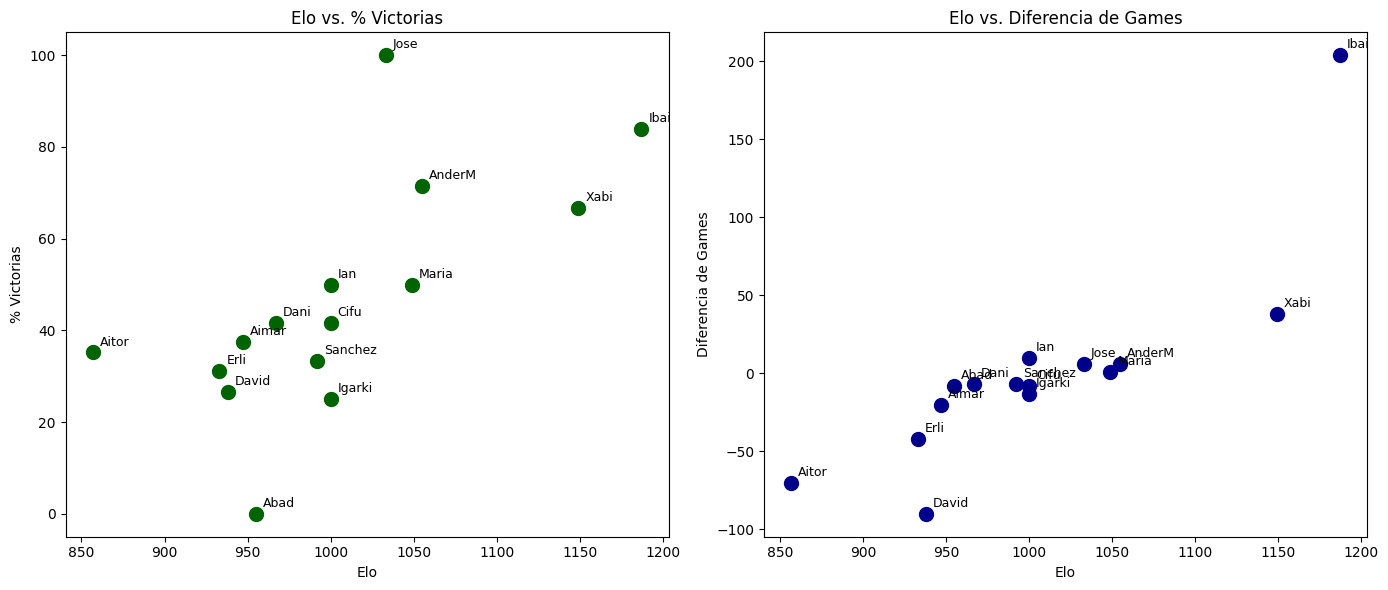

In [13]:
import itertools
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
import csv
import json
from tkcalendar import DateEntry  # pip install tkcalendar
import sys, os, math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from collections import defaultdict

# -------------------------------------------------------------------
# 1. Función resource_path (si empaquetas con PyInstaller)
# -------------------------------------------------------------------
def resource_path(relative_path):
    try:
        base_path = sys._MEIPASS
    except AttributeError:
        base_path = os.path.abspath(".")
    return os.path.join(base_path, relative_path)

# -------------------------------------------------------------------
# 2. Función para determinar la Season según la fecha
# -------------------------------------------------------------------
def obtener_season(fecha_str):
    """
    Recibe una fecha en formato 'YYYY-MM-DD' y retorna:
      - "Season 0" si la fecha es anterior al 1/1/2025.
      - A partir del 1/1/2025, "Season N" donde N incrementa cada 6 meses.
    """
    try:
        fecha = datetime.strptime(fecha_str, '%Y-%m-%d')
    except Exception:
        return "Unknown"

    limite = datetime(2025, 1, 1)
    if fecha < limite:
        return "Season 0"
    else:
        year_diff = fecha.year - 2025
        if fecha.month <= 6:
            sem = 0
        else:
            sem = 1
        season_num = 1 + (2 * year_diff) + sem
        return f"Season {season_num}"

# -------------------------------------------------------------------
# 3. Estructuras principales
# -------------------------------------------------------------------
jugadores = []
resultados = []
parejas = []
equipos_str = []
equipo_str_a_pareja = {}

ranking_elo_por_season = {}
elo_changes_por_partido = {}

# -------------------------------------------------------------------
# 4. Leer y guardar jugadores
# -------------------------------------------------------------------
archivo_jugadores = resource_path("jugadores.json")
def leer_jugadores():
    global jugadores
    if os.path.exists(archivo_jugadores):
        try:
            with open(archivo_jugadores, "r", encoding="utf-8") as f:
                jugadores = json.load(f)
        except Exception as e:
            print("Error al leer el archivo de jugadores:", e)
            jugadores = []
    else:
        # Lista inicial
        jugadores = ["Ibai", "Xabi", "Ian", "Aitor", "Cifu", "David",
                     "Igarki", "Aimar", "Erli", "Maria", "Dani", "AnderM",
                     "Abad", "Sanchez"]
    
    # Ordenar la lista de jugadores alfabéticamente
    jugadores.sort()

def guardar_jugadores():
    with open(archivo_jugadores, "w", encoding="utf-8") as f:
        json.dump(jugadores, f, ensure_ascii=False, indent=4)

# -------------------------------------------------------------------
# 5. Leer resultados desde CSV
# -------------------------------------------------------------------
archivo_resultados = resource_path("resultados.csv")

def leer_resultados():
    global resultados
    resultados.clear()
    if os.path.exists(archivo_resultados):
        with open(archivo_resultados, mode='r', newline='', encoding='utf-8-sig') as file:
            reader = csv.DictReader(file)
            for row in reader:
                try:
                    eq1j1 = row.get("equipo1_jugador1", "").strip()
                    eq1j2 = row.get("equipo1_jugador2", "").strip()
                    eq2j1 = row.get("equipo2_jugador1", "").strip()
                    eq2j2 = row.get("equipo2_jugador2", "").strip()
                    g1s1 = row.get("ganador_primer_set_jugador1", "").strip()
                    g1s2 = row.get("ganador_primer_set_jugador2", "").strip()
                    gpart1 = row.get("ganador_partido_jugador1", "").strip()
                    gpart2 = row.get("ganador_partido_jugador2", "").strip()
                    puntuaciones = row.get("puntuaciones", "").split(';') if row.get("puntuaciones") else []
                    fecha_str = row.get("fecha", "").strip()
                    season = row.get("season")
                    if not season:
                        season = obtener_season(fecha_str)

                    resultado = {
                        "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
                        "ganador_primer_set": (g1s1, g1s2),
                        "ganador_partido": (gpart1, gpart2),
                        "mvp": row.get("mvp", "").strip(),
                        "puntuaciones": puntuaciones,
                        "tie_breaks": int(row["tie_breaks"]) if row.get("tie_breaks") else 0,
                        "lugar": row.get("lugar", "").strip(),
                        "fecha": fecha_str,
                        "season": season
                    }
                    resultados.append(resultado)
                except Exception as e:
                    print(f"Error procesando fila: {row}, Error: {e}")

# -------------------------------------------------------------------
# 6. Guardar resultado en CSV
# -------------------------------------------------------------------
def guardar_resultado_csv(resultado):
    file_exists = os.path.exists(archivo_resultados)
    fieldnames = [
        "equipo1_jugador1", "equipo1_jugador2",
        "equipo2_jugador1", "equipo2_jugador2",
        "ganador_primer_set_jugador1", "ganador_primer_set_jugador2",
        "ganador_partido_jugador1", "ganador_partido_jugador2",
        "mvp", "puntuaciones", "tie_breaks", "lugar", "fecha", "season"
    ]
    with open(archivo_resultados, mode='a', newline='', encoding='utf-8-sig') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow({
            "equipo1_jugador1": resultado["partido"][0][0],
            "equipo1_jugador2": resultado["partido"][0][1],
            "equipo2_jugador1": resultado["partido"][1][0],
            "equipo2_jugador2": resultado["partido"][1][1],
            "ganador_primer_set_jugador1": resultado["ganador_primer_set"][0],
            "ganador_primer_set_jugador2": resultado["ganador_primer_set"][1],
            "ganador_partido_jugador1": resultado["ganador_partido"][0],
            "ganador_partido_jugador2": resultado["ganador_partido"][1],
            "mvp": resultado["mvp"],
            "puntuaciones": ';'.join(resultado["puntuaciones"]),
            "tie_breaks": resultado["tie_breaks"],
            "lugar": resultado["lugar"],
            "fecha": resultado["fecha"],
            "season": resultado["season"]
        })

# -------------------------------------------------------------------
# 7. Funciones para recalcular Elo por Season
# -------------------------------------------------------------------
def actualizar_datos_equipos():
    global parejas, equipos_str, equipo_str_a_pareja
    parejas = list(itertools.combinations(jugadores, 2))
    equipos_str = ["{} & {}".format(j1, j2) for (j1, j2) in parejas]
    equipo_str_a_pareja = dict(zip(equipos_str, parejas))

def calcular_probabilidad_elo(rA, rB):
    return 1 / (1 + math.pow(10, (rB - rA) / 400))

def actualizar_elo_sin_guardar(ranking_local, partido):
    equipo1, equipo2 = partido["partido"]
    ganador = partido["ganador_partido"]
    K = 56  # Factor K

    cambios = {}
    for jugador in equipo1 + equipo2:
        cambios[jugador] = ranking_local[jugador]

    # Actualizamos el Elo de cada jugador del equipo1
    for jugador in equipo1:
        r = ranking_local[jugador]
        r_opp1 = ranking_local[equipo2[0]]
        r_opp2 = ranking_local[equipo2[1]]
        probabilidad = (1 / (1 + 10 ** ((r_opp1 - r) / 400))
                        + 1 / (1 + 10 ** ((r_opp2 - r) / 400))) / 2
        resultado = 1 if jugador in ganador else 0
        ranking_local[jugador] = round(r + K * (resultado - probabilidad))

    # Actualizamos el Elo de cada jugador del equipo2
    for jugador in equipo2:
        r = ranking_local[jugador]
        r_opp1 = ranking_local[equipo1[0]]
        r_opp2 = ranking_local[equipo1[1]]
        probabilidad = (1 / (1 + 10 ** ((r_opp1 - r) / 400))
                        + 1 / (1 + 10 ** ((r_opp2 - r) / 400))) / 2
        resultado = 1 if jugador in ganador else 0
        ranking_local[jugador] = round(r + K * (resultado - probabilidad))

    for jugador in equipo1 + equipo2:
        cambios[jugador] = ranking_local[jugador] - cambios[jugador]
    return cambios

def recalcular_elo_por_season():
    ranking_elo_por_season.clear()
    elo_changes_por_partido.clear()

    from collections import defaultdict
    seasons_dict = defaultdict(list)
    for idx, partido in enumerate(resultados):
        season = partido["season"]
        seasons_dict[season].append((idx, partido))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        else:
            try:
                return int(s.split()[1])
            except:
                return 9999
    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    for season in sorted_seasons:
        ranking_local = {j: 1000 for j in jugadores}
        lista_partidos = seasons_dict[season]
        lista_partidos.sort(key=lambda x: x[1]["fecha"])

        for (idx, p) in lista_partidos:
            cambios = actualizar_elo_sin_guardar(ranking_local, p)
            elo_changes_por_partido[idx] = cambios

        ranking_elo_por_season[season] = ranking_local.copy()

# -------------------------------------------------------------------
# 8. Función para asignar animal según Elo
# -------------------------------------------------------------------
def asignar_animal_por_elo(elo):
    """
    Asigna un animal según el Elo, de menor a mayor peligrosidad.
    Caso especial: Elo == 1000 => un animal doméstico (ej. "Cerdo").
    """
    if elo < 700:
        return "Hormiga"
    elif 700 <= elo < 750:
        return "Escapatrajo"
    elif 750 <= elo < 800:
        return "Besugo"
    elif 800 <= elo < 850:
        return "Borrego"
    elif 850 <= elo < 900:
        return "Merluza"
    elif 900 <= elo < 950:
        return "Panda"
    elif 950 <= elo < 1000:
        return "Mono"
    elif elo == 1000:
        return "Cerdo"  # Animal doméstico específico
    elif 1000 < elo < 1050:
        return "Caballo"
    elif 1050 < elo < 1100:
        return "Lobo"
    elif 1100 <= elo < 1200:
        return "Zorro"
    elif 1200 <= elo < 1300:
        return "León"
    elif 1300 <= elo < 1400:
        return "Tigre"
    elif 1400 <= elo < 1500:
        return "Rinoceronte"
    else:
        # Elo >= 1500
        return "Dragón"

# -------------------------------------------------------------------
# 9. Mostrar Ranking Elo (Seasons) con columna Animal
# -------------------------------------------------------------------
def mostrar_ranking_elo():
    recalcular_elo_por_season()

    ranking_window = tk.Toplevel()
    ranking_window.title("Ranking Elo (por Seasons)")
    ranking_window.geometry("800x600")

    notebook = ttk.Notebook(ranking_window)
    notebook.pack(expand=True, fill="both")

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        else:
            try:
                return int(s.split()[1])
            except:
                return 9999
    sorted_seasons = sorted(ranking_elo_por_season.keys(), key=season_sort_key)

    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)

        ranking_local = ranking_elo_por_season[season]
        ranking_ordenado = sorted(ranking_local.items(), key=lambda x: x[1], reverse=True)

        # Añadimos la columna "Animal"
        tree = ttk.Treeview(frame, columns=("Pos", "Jugador", "Elo", "Animal"), show='headings')
        tree.heading("Pos", text="Posición")
        tree.heading("Jugador", text="Jugador")
        tree.heading("Elo", text="Elo")
        tree.heading("Animal", text="Animal")

        tree.column("Pos", anchor="center", width=80)
        tree.column("Jugador", anchor="center", width=150)
        tree.column("Elo", anchor="center", width=80)
        tree.column("Animal", anchor="center", width=120)

        pos = 1
        for (jug, elo) in ranking_ordenado:
            animal = asignar_animal_por_elo(elo)
            tree.insert("", tk.END, values=(pos, jug, elo, animal))
            pos += 1

        tree.pack(expand=True, fill="both")

# -------------------------------------------------------------------
# 10. Mostrar Partidos (por Season) con columna Elo
# -------------------------------------------------------------------
def mostrar_partidos():
    recalcular_elo_por_season()

    partidos_window = tk.Toplevel()
    partidos_window.title("Lista de Partidos")
    partidos_window.geometry("1000x600")

    style = ttk.Style(partidos_window)
    style.theme_use('clam')
    style.configure('Treeview', background='#E3F2FD', foreground='black',
                    rowheight=25, fieldbackground='#E3F2FD')
    style.configure('Treeview.Heading', background='#1E88E5',
                    foreground='white', font=('Helvetica', 10, 'bold'))

    filtro_frame = tk.Frame(partidos_window)
    filtro_frame.pack(pady=5)

    tk.Label(filtro_frame, text="Filtrar por Jugador:", font=('Helvetica', 12)).grid(row=0, column=0, padx=5)
    jugador_filtro_var = tk.StringVar(value="Todos")
    lista_jugadores_filtro = ["Todos"] + jugadores
    jugador_filtro_combobox = ttk.Combobox(filtro_frame, textvariable=jugador_filtro_var,
                                           values=lista_jugadores_filtro, state='readonly')
    jugador_filtro_combobox.grid(row=0, column=1, padx=5)

    notebook = ttk.Notebook(partidos_window)
    notebook.pack(expand=True, fill='both')

    from collections import defaultdict
    seasons_dict = defaultdict(list)
    for idx, r in enumerate(resultados):
        season = r["season"]
        seasons_dict[season].append((idx, r))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        else:
            try:
                return int(s.split()[1])
            except:
                return 9999
    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    treeviews = {}
    columnas = ["Fecha", "Equipo 1", "Equipo 2", "Puntuaciones",
                "Ganador", "MVP", "Tie-breaks", "Lugar", "Elo"]
    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)
        tree = ttk.Treeview(frame, columns=columnas, show='headings')
        for col in columnas:
            tree.heading(col, text=col)
            tree.column(col, anchor='center', width=120, stretch=False)
        tree.pack(expand=True, fill='both')

        scrollbar_y = ttk.Scrollbar(frame, orient='vertical', command=tree.yview)
        scrollbar_y.pack(side='right', fill='y')
        tree.configure(yscrollcommand=scrollbar_y.set)

        treeviews[season] = tree

    def actualizar_partidos():
        filtro = jugador_filtro_var.get()

        for season in sorted_seasons:
            tree = treeviews[season]
            tree.delete(*tree.get_children())
            lista_partidos = seasons_dict[season]
            lista_partidos.sort(key=lambda x: x[1]["fecha"])

            for (idx, r) in lista_partidos:
                fecha = r["fecha"]
                eq1_str = " & ".join(r["partido"][0])
                eq2_str = " & ".join(r["partido"][1])
                puntuaciones = "; ".join(r["puntuaciones"]) if r["puntuaciones"] else "N/A"
                ganador = " & ".join(r["ganador_partido"])
                mvp = r["mvp"]
                tie_breaks = r["tie_breaks"]
                lugar = r["lugar"]

                if filtro == "Todos":
                    mostrar = True
                else:
                    jug_partido = list(r["partido"][0]) + list(r["partido"][1])
                    mostrar = (filtro in jug_partido)

                if mostrar:
                    elo_val = ""
                    if filtro != "Todos":
                        cambios = elo_changes_por_partido.get(idx, {})
                        if filtro in cambios:
                            diff = cambios[filtro]
                            if diff > 0:
                                elo_val = f"+{diff}"
                            else:
                                elo_val = f"{diff}"

                    tree.insert("", tk.END, values=(fecha, eq1_str, eq2_str,
                                                    puntuaciones, ganador, mvp,
                                                    tie_breaks, lugar, elo_val))

    jugador_filtro_combobox.bind("<<ComboboxSelected>>", lambda e: actualizar_partidos())
    actualizar_partidos()

    ttk.Button(partidos_window, text="Cerrar", command=partidos_window.destroy).pack(pady=5)

# -------------------------------------------------------------------
# 11. Estadísticas avanzadas por jugador
# -------------------------------------------------------------------
def estadisticas_jugador_detalladas(player):
    """
    Devuelve un diccionario con:
      - fiel_companero: (nombre_aliado, num_partidos)
      - mejor_aliado: (nombre_aliado, ratio)
      - peor_aliado: (nombre_aliado, ratio)
      - mayor_enemigo: (nombre_enemigo, victorias_sobre_el_jugador)
      - enemigo_mas_debil: (nombre_enemigo, derrotas_contra_el_jugador)
      - archirrival: (nombre_enemigo, num_partidos)
    """
    ally_data = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})
    enemy_data = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})

    for match in resultados:
        eq1, eq2 = match["partido"]
        winner = match["ganador_partido"]

        if player in eq1:
            if eq1[0] == player:
                ally = eq1[1]
            else:
                ally = eq1[0]
            opp1, opp2 = eq2[0], eq2[1]
            if set(eq1) == set(winner):
                ally_data[ally]["wins"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["losses"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["losses"] += 1
                enemy_data[opp2]["games"] += 1
            else:
                ally_data[ally]["losses"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["wins"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["wins"] += 1
                enemy_data[opp2]["games"] += 1

        elif player in eq2:
            if eq2[0] == player:
                ally = eq2[1]
            else:
                ally = eq2[0]
            opp1, opp2 = eq1[0], eq1[1]
            if set(eq2) == set(winner):
                ally_data[ally]["wins"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["losses"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["losses"] += 1
                enemy_data[opp2]["games"] += 1
            else:
                ally_data[ally]["losses"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["wins"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["wins"] += 1
                enemy_data[opp2]["games"] += 1

    # Fiel compañero: más partidos juntos
    if ally_data:
        ally_list = [(a, d) for a, d in ally_data.items() if d["games"] > 0]
        if ally_list:
            fiel_companero = max(ally_list, key=lambda x: x[1]["games"])
            fiel_companero_name = fiel_companero[0]
            fiel_companero_games = fiel_companero[1]["games"]
        else:
            fiel_companero_name, fiel_companero_games = "N/A", 0
    else:
        fiel_companero_name, fiel_companero_games = "N/A", 0

    # Mejor / Peor aliado: ratio de victorias
    def ally_ratio(a):
        return a["wins"] / a["games"] if a["games"] > 0 else 0

    if ally_data:
        valid_allies = [(ally, info) for ally, info in ally_data.items() if info["games"] > 0]
        if valid_allies:
            best_ally = max(valid_allies, key=lambda item: ally_ratio(item[1]))
            worst_ally = min(valid_allies, key=lambda item: ally_ratio(item[1]))
            mejor_aliado_name = best_ally[0]
            mejor_aliado_ratio = ally_ratio(best_ally[1])
            peor_aliado_name = worst_ally[0]
            peor_aliado_ratio = ally_ratio(worst_ally[1])
        else:
            mejor_aliado_name, mejor_aliado_ratio = "N/A", 0
            peor_aliado_name, peor_aliado_ratio = "N/A", 0
    else:
        mejor_aliado_name, mejor_aliado_ratio = "N/A", 0
        peor_aliado_name, peor_aliado_ratio = "N/A", 0

    # Mayor enemigo, enemigo más débil, archirrival
    if enemy_data:
        valid_enemies = [(e, d) for e, d in enemy_data.items() if d["games"] > 0]
        if valid_enemies:
            biggest_enemy = max(valid_enemies, key=lambda x: x[1]["wins"])
            mayor_enemigo_name = biggest_enemy[0]
            mayor_enemigo_wins = biggest_enemy[1]["wins"]

            weakest_enemy = max(valid_enemies, key=lambda x: x[1]["losses"])
            enemigo_mas_debil_name = weakest_enemy[0]
            enemigo_mas_debil_losses = weakest_enemy[1]["losses"]

            archirrival = max(valid_enemies, key=lambda x: x[1]["games"])
            archirrival_name = archirrival[0]
            archirrival_games = archirrival[1]["games"]
        else:
            mayor_enemigo_name, mayor_enemigo_wins = "N/A", 0
            enemigo_mas_debil_name, enemigo_mas_debil_losses = "N/A", 0
            archirrival_name, archirrival_games = "N/A", 0
    else:
        mayor_enemigo_name, mayor_enemigo_wins = "N/A", 0
        enemigo_mas_debil_name, enemigo_mas_debil_losses = "N/A", 0
        archirrival_name, archirrival_games = "N/A", 0

    return {
        "fiel_companero": (fiel_companero_name, fiel_companero_games),
        "mejor_aliado": (mejor_aliado_name, mejor_aliado_ratio),
        "peor_aliado": (peor_aliado_name, peor_aliado_ratio),
        "mayor_enemigo": (mayor_enemigo_name, mayor_enemigo_wins),
        "enemigo_mas_debil": (enemigo_mas_debil_name, enemigo_mas_debil_losses),
        "archirrival": (archirrival_name, archirrival_games),
    }

def mostrar_estadisticas_jugador_avanzadas():
    """
    Ventana con un Combobox para elegir un jugador y, al seleccionarlo,
    muestra:
      - Fiel compañero
      - Mejor aliado
      - Peor aliado
      - Mayor enemigo
      - Enemigo más débil
      - Archirrival
    """
    window = tk.Toplevel()
    window.title("Estadísticas Avanzadas por Jugador")
    window.geometry("500x400")

    tk.Label(window, text="Selecciona Jugador:").pack(pady=5)
    player_var = tk.StringVar(value="")
    cb_jugadores = ttk.Combobox(window, textvariable=player_var,
                                values=jugadores, state='readonly')
    cb_jugadores.pack(pady=5)

    stats_text = tk.Text(window, width=60, height=15)
    stats_text.pack(pady=10)

    def on_player_selected(event):
        player = player_var.get()
        if not player:
            return

        info = estadisticas_jugador_detalladas(player)

        fiel_companero_name, fiel_companero_games = info["fiel_companero"]
        mejor_aliado_name, mejor_aliado_ratio = info["mejor_aliado"]
        peor_aliado_name, peor_aliado_ratio = info["peor_aliado"]
        mayor_enemigo_name, mayor_enemigo_wins = info["mayor_enemigo"]
        enemigo_mas_debil_name, enemigo_mas_debil_losses = info["enemigo_mas_debil"]
        archirrival_name, archirrival_games = info["archirrival"]

        mejor_aliado_percent = f"{mejor_aliado_ratio*100:.1f}%" if mejor_aliado_ratio else "0%"
        peor_aliado_percent = f"{peor_aliado_ratio*100:.1f}%" if peor_aliado_ratio else "0%"

        texto_final = (
            f"Estadísticas de {player}:\n\n"
            f"  • Fiel compañero: {fiel_companero_name} (juntos {fiel_companero_games} partidos)\n"
            f"  • Mejor aliado: {mejor_aliado_name} (ratio: {mejor_aliado_percent})\n"
            f"  • Peor aliado: {peor_aliado_name} (ratio: {peor_aliado_percent})\n\n"
            f"  • Mayor enemigo: {mayor_enemigo_name} (te ha ganado {mayor_enemigo_wins} veces)\n"
            f"  • Enemigo más débil: {enemigo_mas_debil_name} (le has ganado {enemigo_mas_debil_losses} veces)\n"
            f"  • Archirrival: {archirrival_name} (os habéis enfrentado {archirrival_games} veces)\n"
        )

        stats_text.delete("1.0", tk.END)
        stats_text.insert(tk.END, texto_final)

    cb_jugadores.bind("<<ComboboxSelected>>", on_player_selected)

# -------------------------------------------------------------------
# 12. Funciones de estadísticas, gráficos, etc.
# -------------------------------------------------------------------
def calcular_estadisticas(resultados_filtrar):
    """
    Calcula estadísticas por jugador:
      - partidos_jugados
      - victorias
      - mvp
      - sets_jugados
      - sets_ganados
      - tie_breaks
      - primer_set_ganado
      - games_ganados
      - games_perdidos
      - porcentaje_victorias
      - porcentaje_primer_set
      - diferencia_games
    """
    lugares = ["Ibaiondo", "Bakh", "Otro"]
    estadisticas = {}
    for j in jugadores:
        estadisticas[j] = {
            "partidos_jugados": 0,
            "victorias": 0,
            "mvp": 0,
            "sets_jugados": 0,
            "sets_ganados": 0,
            "tie_breaks": 0,
            "primer_set_ganado": 0,
            "games_ganados": 0,
            "games_perdidos": 0,
            "victorias_por_lugar": {l: 0 for l in lugares}
        }
    for r in resultados_filtrar:
        equipo1, equipo2 = r["partido"]
        ganador = r["ganador_partido"]
        mvp = r["mvp"]
        lugar = r["lugar"]
        sets_jugados = len(r["puntuaciones"])

        for jug in equipo1 + equipo2:
            if jug not in estadisticas:
                estadisticas[jug] = {
                    "partidos_jugados": 0,
                    "victorias": 0,
                    "mvp": 0,
                    "sets_jugados": 0,
                    "sets_ganados": 0,
                    "tie_breaks": 0,
                    "primer_set_ganado": 0,
                    "games_ganados": 0,
                    "games_perdidos": 0,
                    "victorias_por_lugar": {l: 0 for l in lugares}
                }
        for jug in equipo1 + equipo2:
            estadisticas[jug]["partidos_jugados"] += 1
            estadisticas[jug]["sets_jugados"] += sets_jugados
        for jug in ganador:
            estadisticas[jug]["victorias"] += 1
            if lugar in estadisticas[jug]["victorias_por_lugar"]:
                estadisticas[jug]["victorias_por_lugar"][lugar] += 1
        for jug in r["ganador_primer_set"]:
            estadisticas[jug]["primer_set_ganado"] += 1

        for set_result in r["puntuaciones"]:
            if '(' in set_result:
                score_part, _ = set_result.split('(')
                s1, s2 = map(int, score_part.split('-'))
                tie_breaks_in_set = 1
            else:
                s1, s2 = map(int, set_result.split('-'))
                tie_breaks_in_set = 0
            for jug in equipo1 + equipo2:
                estadisticas[jug]["tie_breaks"] += tie_breaks_in_set
            if s1 > s2:
                for jug in equipo1:
                    estadisticas[jug]["sets_ganados"] += 1
            else:
                for jug in equipo2:
                    estadisticas[jug]["sets_ganados"] += 1
            for jug in equipo1:
                estadisticas[jug]["games_ganados"] += s1
                estadisticas[jug]["games_perdidos"] += s2
            for jug in equipo2:
                estadisticas[jug]["games_ganados"] += s2
                estadisticas[jug]["games_perdidos"] += s1
        if mvp in estadisticas:
            estadisticas[mvp]["mvp"] += 1

    for jug, st in estadisticas.items():
        pj = st["partidos_jugados"]
        if pj > 0:
            st["porcentaje_victorias"] = st["victorias"] / pj * 100
            st["porcentaje_primer_set"] = st["primer_set_ganado"] / pj * 100
        else:
            st["porcentaje_victorias"] = 0
            st["porcentaje_primer_set"] = 0
        st["diferencia_games"] = st["games_ganados"] - st["games_perdidos"]
    return estadisticas

def mostrar_grafico_jugadores():
    recalcular_elo_por_season()
    if not ranking_elo_por_season:
        messagebox.showinfo("Info", "No hay datos de Elo para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999
    sorted_seasons = sorted(ranking_elo_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_elo_por_season[last_season]

    fig, ax = plt.subplots(figsize=(8, 6))
    jugadores_ = list(ranking.keys())
    elo_values = list(ranking.values())
    ax.bar(jugadores_, elo_values, color='steelblue')
    ax.set_title(f"Ranking Elo - {last_season}")
    ax.set_xlabel("Jugador")
    ax.set_ylabel("Elo")
    ax.set_xticklabels(jugadores_, rotation=45, ha="right")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico de Jugadores")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_grafico_acumulado():
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para mostrar.")
        return

    sorted_resultados = sorted(resultados, key=lambda r: r["fecha"])
    ranking = {jug: 1000 for jug in jugadores}
    history = {jug: [] for jug in jugadores}
    first_date = datetime.strptime(sorted_resultados[0]["fecha"], '%Y-%m-%d')
    for jug in jugadores:
        history[jug].append((first_date, 1000))

    for r in sorted_resultados:
        match_date = datetime.strptime(r["fecha"], '%Y-%m-%d')
        actualizar_elo_sin_guardar(ranking, r)
        for jug in jugadores:
            history[jug].append((match_date, ranking[jug]))

    fig, ax = plt.subplots(figsize=(10, 6))
    for jug in jugadores:
        dates = [p[0] for p in history[jug]]
        elos = [p[1] for p in history[jug]]
        ax.plot(dates, elos, label=jug)
    ax.set_title("Evolución Acumulada del Elo")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Elo")
    ax.legend(loc='best', fontsize='small')
    fig.autofmt_xdate()
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico Acumulado")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_heatmap_partidos_vs_ratio():
    from itertools import combinations
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para calcular el heatmap.")
        return

    pair_matches = {}
    pair_wins = {}
    for pair in combinations(jugadores, 2):
        p = tuple(sorted(pair))
        pair_matches[p] = 0
        pair_wins[p] = 0

    for r in resultados:
        equipo1, equipo2 = r["partido"]
        ganador = r["ganador_partido"]

        if set(ganador) == set(equipo1):
            perdedor = equipo2
        else:
            perdedor = equipo1

        w = tuple(sorted(ganador))
        l = tuple(sorted(perdedor))
        pair_matches[w] += 1
        pair_wins[w] += 1
        pair_matches[l] += 1

    n = len(jugadores)
    idx_map = {jug: i for i, jug in enumerate(jugadores)}
    T = np.zeros((n, n), dtype=int)
    R = np.zeros((n, n), dtype=float)

    for (p1, p2), total in pair_matches.items():
        i = idx_map[p1]
        j = idx_map[p2]
        wins = pair_wins[(p1, p2)]
        ratio = wins / total if total > 0 else 0
        T[i, j] = total
        T[j, i] = total
        R[i, j] = ratio
        R[j, i] = ratio

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(R, vmin=0, vmax=1, cmap="Greens", alpha=0.8)
    ax.set_title("Heatmap: Partidos Totales (texto) vs. Porcentaje de Victorias (color)")
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(jugadores, rotation=45, ha="right")
    ax.set_yticklabels(jugadores)

    for i in range(n):
        for j in range(n):
            if i != j:
                text = str(T[i, j])
                ax.text(j, i, text, ha="center", va="center", color="black", fontsize=9)
            else:
                ax.text(j, i, "", ha="center", va="center", color="black")

    cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Ratio de Victorias", rotation=90)

    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Heatmap Partidos vs. Ratio")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_scatter_elo_vs_metricas():
    recalcular_elo_por_season()
    if not ranking_elo_por_season:
        messagebox.showinfo("Info", "No hay datos de Elo para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999
    sorted_seasons = sorted(ranking_elo_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_elo_por_season[last_season]

    stats = calcular_estadisticas(resultados)
    elo_list = []
    win_perc_list = []
    game_diff_list = []
    names = []
    for jug in jugadores:
        elo = ranking.get(jug, 1000)
        win_perc = stats[jug]["porcentaje_victorias"]
        game_diff = stats[jug]["diferencia_games"]
        elo_list.append(elo)
        win_perc_list.append(win_perc)
        game_diff_list.append(game_diff)
        names.append(jug)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.scatter(elo_list, win_perc_list, color="darkgreen", s=100)
    for i, name in enumerate(names):
        ax1.annotate(name, (elo_list[i], win_perc_list[i]),
                     textcoords="offset points", xytext=(5,5), fontsize=9)
    ax1.set_xlabel("Elo")
    ax1.set_ylabel("% Victorias")
    ax1.set_title("Elo vs. % Victorias")

    ax2.scatter(elo_list, game_diff_list, color="darkblue", s=100)
    for i, name in enumerate(names):
        ax2.annotate(name, (elo_list[i], game_diff_list[i]),
                     textcoords="offset points", xytext=(5,5), fontsize=9)
    ax2.set_xlabel("Elo")
    ax2.set_ylabel("Diferencia de Games")
    ax2.set_title("Elo vs. Diferencia de Games")

    fig.tight_layout()
    win = tk.Toplevel()
    win.title("Scatter Plot: Elo vs. Métricas")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_scatter_elo_vs_partidos():
    recalcular_elo_por_season()
    if not ranking_elo_por_season:
        messagebox.showinfo("Info", "No hay datos de Elo para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999
    sorted_seasons = sorted(ranking_elo_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_elo_por_season[last_season]

    stats = calcular_estadisticas(resultados)
    x_partidos = []
    y_elo = []
    labels = []

    for jug in jugadores:
        partidos_jugados = stats[jug]["partidos_jugados"]
        elo_jugador = ranking.get(jug, 1000)
        x_partidos.append(partidos_jugados)
        y_elo.append(elo_jugador)
        labels.append(jug)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x_partidos, y_elo, color="dodgerblue", s=100)
    for i, name in enumerate(labels):
        ax.annotate(name, (x_partidos[i], y_elo[i]),
                    textcoords="offset points", xytext=(5,5), fontsize=9)

    ax.set_xlabel("Partidos Totales")
    ax.set_ylabel("Elo (Último Season)")
    ax.set_title("Elo vs. Partidos Totales")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Scatter: Elo vs. Partidos Totales")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# -------------------------------------------------------------------
# 13. Mostrar Estadísticas Generales
# -------------------------------------------------------------------
def mostrar_estadisticas():
    stats = calcular_estadisticas(resultados)

    stats_window = tk.Toplevel()
    stats_window.title("Estadísticas de Jugadores")
    stats_window.geometry("1000x600")

    columnas = ("Jugador", "PJ", "Vict", "%Vict", "SetsJug", "SetsGan",
                "GamesGan", "GamesPer", "DifGames", "MVP", "TieBreaks", "%PrimerSet")
    tree = ttk.Treeview(stats_window, columns=columnas, show='headings')

    tree.heading("Jugador", text="Jugador")
    tree.heading("PJ", text="PJ")
    tree.heading("Vict", text="Vict")
    tree.heading("%Vict", text="%Vict")
    tree.heading("SetsJug", text="Sets Jug")
    tree.heading("SetsGan", text="Sets Gan")
    tree.heading("GamesGan", text="Games Gan")
    tree.heading("GamesPer", text="Games Per")
    tree.heading("DifGames", text="Dif Games")
    tree.heading("MVP", text="MVP")
    tree.heading("TieBreaks", text="TieBreaks")
    tree.heading("%PrimerSet", text="%1erSet")

    for col in columnas:
        tree.column(col, anchor='center', width=80)

    for jug, st in stats.items():
        pj = st["partidos_jugados"]
        vict = st["victorias"]
        porc_vict = f"{st['porcentaje_victorias']:.1f}%"
        sets_jug = st["sets_jugados"]
        sets_gan = st["sets_ganados"]
        games_gan = st["games_ganados"]
        games_per = st["games_perdidos"]
        dif_games = st["diferencia_games"]
        mvp = st["mvp"]
        tie_b = st["tie_breaks"]
        porc_pset = f"{st['porcentaje_primer_set']:.1f}%"

        tree.insert("", tk.END, values=(
            jug, pj, vict, porc_vict, sets_jug, sets_gan,
            games_gan, games_per, dif_games, mvp, tie_b, porc_pset
        ))

    tree.pack(side='left', fill='both', expand=True)
    scrollbar_y = ttk.Scrollbar(stats_window, orient='vertical', command=tree.yview)
    scrollbar_y.pack(side='right', fill='y')
    tree.configure(yscrollcommand=scrollbar_y.set)

# -------------------------------------------------------------------
# 14. Interfaz principal
# -------------------------------------------------------------------
def crear_interfaz():
    root = tk.Tk()
    root.title("Registrar Resultado de Partido")
    root.geometry("900x700")

    style = ttk.Style(root)
    style.theme_use('clam')
    primary_color = '#1E88E5'
    background_color = '#E3F2FD'
    root.configure(bg=background_color)
    style.configure('TButton', font=('Segoe UI', 10), padding=5)
    style.configure('TLabel', font=('Segoe UI', 10))
    style.configure('TCombobox', font=('Segoe UI', 10))

    menu_bar = tk.Menu(root)
    navegacion_menu = tk.Menu(menu_bar, tearoff=0)
    navegacion_menu.add_command(label="Gráfico Jugadores", command=mostrar_grafico_jugadores)
    navegacion_menu.add_command(label="Gráfico Acumulado", command=mostrar_grafico_acumulado)
    navegacion_menu.add_command(label="Heatmap Partidos vs. Ratio", command=mostrar_heatmap_partidos_vs_ratio)
    navegacion_menu.add_command(label="Scatter: Elo vs. Partidos", command=mostrar_scatter_elo_vs_partidos)
    navegacion_menu.add_command(label="Scatter: Elo vs Métricas", command=mostrar_scatter_elo_vs_metricas)
    navegacion_menu.add_command(label="Estadísticas", command=mostrar_estadisticas)
    navegacion_menu.add_command(label="Datos Curiosos", command=mostrar_estadisticas_jugador_avanzadas)

    menu_bar.add_cascade(label="Navegación", menu=navegacion_menu)
    root.config(menu=menu_bar)

    tk.Label(root, text="Fecha del Partido (YYYY-mm-dd):", bg=background_color).grid(row=0, column=0, sticky='e')
    fecha_var = DateEntry(root, width=12, background='darkblue', foreground='white',
                          borderwidth=2, date_pattern='y-mm-dd')
    fecha_var.grid(row=0, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 1:", bg=background_color).grid(row=1, column=0, sticky='e')
    equipo1_j1_var = tk.StringVar()
    equipo1_j1_cb = ttk.Combobox(root, textvariable=equipo1_j1_var, values=jugadores, state='readonly')
    equipo1_j1_cb.grid(row=1, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 2:", bg=background_color).grid(row=2, column=0, sticky='e')
    equipo1_j2_var = tk.StringVar()
    equipo1_j2_cb = ttk.Combobox(root, textvariable=equipo1_j2_var, values=jugadores, state='readonly')
    equipo1_j2_cb.grid(row=2, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 1:", bg=background_color).grid(row=3, column=0, sticky='e')
    equipo2_j1_var = tk.StringVar()
    equipo2_j1_cb = ttk.Combobox(root, textvariable=equipo2_j1_var, values=jugadores, state='readonly')
    equipo2_j1_cb.grid(row=3, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 2:", bg=background_color).grid(row=4, column=0, sticky='e')
    equipo2_j2_var = tk.StringVar()
    equipo2_j2_cb = ttk.Combobox(root, textvariable=equipo2_j2_var, values=jugadores, state='readonly')
    equipo2_j2_cb.grid(row=4, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador 1er Set:", bg=background_color).grid(row=5, column=0, sticky='e')
    ganador_primer_set_var = tk.StringVar()
    ganador_primer_set_cb = ttk.Combobox(root, textvariable=ganador_primer_set_var,
                                         values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_primer_set_cb.grid(row=5, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador Partido:", bg=background_color).grid(row=6, column=0, sticky='e')
    ganador_partido_var = tk.StringVar()
    ganador_partido_cb = ttk.Combobox(root, textvariable=ganador_partido_var,
                                      values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_partido_cb.grid(row=6, column=1, pady=5, padx=5)

    tk.Label(root, text="MVP:", bg=background_color).grid(row=7, column=0, sticky='e')
    mvp_jugador = ttk.Combobox(root, values=jugadores, state='readonly')
    mvp_jugador.grid(row=7, column=1, pady=5, padx=5)

    set_resultados = {}
    tie_break_vars = {}
    tie_break_scores = {}

    def toggle_tiebreak_entry(num):
        if tie_break_vars[num].get():
            tie_break_scores[num].config(state='normal')
        else:
            tie_break_scores[num].delete(0, tk.END)
            tie_break_scores[num].config(state='disabled')

    for i in range(1, 4):
        tk.Label(root, text=f"Set {i} (ej: 6-4):", bg=background_color).grid(row=7 + i, column=0, sticky='e')
        set_resultados[i] = ttk.Entry(root)
        set_resultados[i].grid(row=7 + i, column=1, pady=5, padx=5)

        tie_break_vars[i] = tk.BooleanVar()
        cb = tk.Checkbutton(root, text="Tie-break", variable=tie_break_vars[i],
                            bg=background_color, command=lambda n=i: toggle_tiebreak_entry(n))
        cb.grid(row=7 + i, column=2, padx=5)

        tk.Label(root, text=f"Puntuación Tie-break Set {i}:", bg=background_color).grid(row=7 + i, column=3, sticky='e')
        tie_break_scores[i] = ttk.Entry(root, state='disabled')
        tie_break_scores[i].grid(row=7 + i, column=4, pady=5, padx=5)

    tk.Label(root, text="Lugar del Partido:", bg=background_color).grid(row=11, column=0, sticky='e')
    lugar_var = tk.StringVar(value="Ibaiondo")
    lugar_menu = ttk.Combobox(root, textvariable=lugar_var, values=["Ibaiondo", "Bakh", "Otro"], state='readonly')
    lugar_menu.grid(row=11, column=1, pady=5, padx=5)

    def registrar_partido():
        eq1j1 = equipo1_j1_var.get()
        eq1j2 = equipo1_j2_var.get()
        eq2j1 = equipo2_j1_var.get()
        eq2j2 = equipo2_j2_var.get()

        if not all([eq1j1, eq1j2, eq2j1, eq2j2]):
            messagebox.showerror("Error", "Faltan jugadores en uno de los equipos.")
            return

        lista_jug = [eq1j1, eq1j2, eq2j1, eq2j2]
        if len(set(lista_jug)) != 4:
            messagebox.showerror("Error", "No se pueden repetir jugadores en el mismo partido.")
            return

        ganador1er = ganador_primer_set_var.get()
        ganadorpart = ganador_partido_var.get()
        if not ganador1er or not ganadorpart:
            messagebox.showerror("Error", "Selecciona ganador de primer set y del partido.")
            return

        if ganador1er == "Equipo 1":
            g1set_equip = (eq1j1, eq1j2)
        else:
            g1set_equip = (eq2j1, eq2j2)

        if ganadorpart == "Equipo 1":
            gpart_equip = (eq1j1, eq1j2)
        else:
            gpart_equip = (eq2j1, eq2j2)

        mvp = mvp_jugador.get()
        if not mvp:
            messagebox.showerror("Error", "Selecciona un MVP.")
            return

        fecha_dt = fecha_var.get_date()
        fecha_str = fecha_dt.strftime('%Y-%m-%d')
        season = obtener_season(fecha_str)

        puntuaciones = []
        tie_breaks_total = 0
        for i in range(1, 4):
            set_val = set_resultados[i].get()
            if set_val:
                try:
                    s1, s2 = map(int, set_val.split('-'))
                except:
                    messagebox.showerror("Error", f"Set {i} inválido. Usa formato n-n.")
                    return
                if tie_break_vars[i].get():
                    tb_score = tie_break_scores[i].get()
                    if not tb_score:
                        messagebox.showerror("Error", f"Falta puntaje tie-break en set {i}.")
                        return
                    set_str = f"{s1}-{s2}({tb_score})"
                    tie_breaks_total += 1
                else:
                    set_str = f"{s1}-{s2}"
                puntuaciones.append(set_str)

        resultado = {
            "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
            "ganador_primer_set": g1set_equip,
            "ganador_partido": gpart_equip,
            "mvp": mvp,
            "puntuaciones": puntuaciones,
            "tie_breaks": tie_breaks_total,
            "lugar": lugar_var.get(),
            "fecha": fecha_str,
            "season": season
        }
        resultados.append(resultado)
        guardar_resultado_csv(resultado)
        messagebox.showinfo("OK", "Partido registrado correctamente.")

        # Limpiar campos
        equipo1_j1_var.set("")
        equipo1_j2_var.set("")
        equipo2_j1_var.set("")
        equipo2_j2_var.set("")
        ganador_primer_set_var.set("")
        ganador_partido_var.set("")
        mvp_jugador.set("")
        for i in range(1, 4):
            set_resultados[i].delete(0, tk.END)
            tie_break_vars[i].set(False)
            tie_break_scores[i].delete(0, tk.END)
            tie_break_scores[i].config(state='disabled')

    btn_frame = tk.Frame(root, bg=background_color)
    btn_frame.grid(row=12, columnspan=5, pady=10)

    tk.Button(btn_frame, text="Registrar Resultado",
              command=registrar_partido, bg=primary_color, fg='white').grid(row=0, column=0, padx=5)
    tk.Button(btn_frame, text="Mostrar Ranking (Seasons)",
              command=mostrar_ranking_elo, bg=primary_color, fg='white').grid(row=0, column=1, padx=5)
    tk.Button(btn_frame, text="Mostrar Partidos (Seasons)",
              command=mostrar_partidos, bg=primary_color, fg='white').grid(row=0, column=2, padx=5)
    tk.Button(btn_frame, text="Gestión de Jugadores",
              command=lambda: gestionar_jugadores(), bg=primary_color, fg='white').grid(row=0, column=3, padx=5)

    def gestionar_jugadores():
        w = tk.Toplevel(root)
        w.title("Gestión de Jugadores")
        listbox = tk.Listbox(w)
        listbox.pack(side='left', fill='both', expand=True)
        scroll = ttk.Scrollbar(w, orient='vertical', command=listbox.yview)
        scroll.pack(side='left', fill='y')
        listbox.config(yscrollcommand=scroll.set)

        def refrescar():
            listbox.delete(0, tk.END)
            for jug in sorted(jugadores):
                listbox.insert(tk.END, jug)

        refrescar()

        def add_jug():
            name = simpledialog.askstring("Nuevo Jugador", "Nombre:")
            if name:
                name = name.strip()
                if name and name not in jugadores:
                    jugadores.append(name)
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def edit_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            old_name = jugadores[idx]
            new_name = simpledialog.askstring("Editar Jugador", "Nuevo nombre:", initialvalue=old_name)
            if new_name:
                new_name = new_name.strip()
                if new_name and new_name not in jugadores:
                    jugadores[idx] = new_name
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def del_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            jug = jugadores[idx]
            if messagebox.askyesno("Confirmar", f"¿Eliminar {jug}?"):
                jugadores.pop(idx)
                guardar_jugadores()
                refrescar()
                actualizar_datos_equipos()

        f_btn = tk.Frame(w)
        f_btn.pack(side='right', fill='y')
        tk.Button(f_btn, text="Agregar", command=add_jug).pack(pady=5)
        tk.Button(f_btn, text="Editar", command=edit_jug).pack(pady=5)
        tk.Button(f_btn, text="Eliminar", command=del_jug).pack(pady=5)

    # Cargar datos al inicio
    leer_jugadores()
    leer_resultados()
    print("Número de resultados leídos:", len(resultados))

    actualizar_datos_equipos()

    root.mainloop()

# -------------------------------------------------------------------
# 15. Iniciar la app
# -------------------------------------------------------------------
if __name__ == "__main__":
    leer_jugadores()
    leer_resultados()
    crear_interfaz()


# MEJORA ELO: TRUESKILL

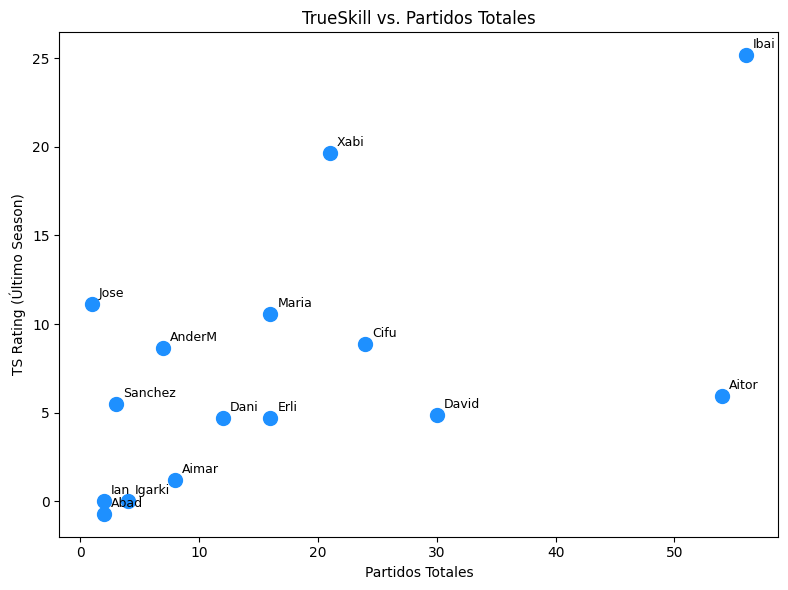

In [14]:
import itertools
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
import csv
import json
from tkcalendar import DateEntry  # pip install tkcalendar
import sys, os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from datetime import datetime
from collections import defaultdict

# TrueSkill
import trueskill

# Configura el entorno TrueSkill (puedes ajustar draw_probability, beta, etc.)
env = trueskill.TrueSkill(draw_probability=0.0)
# Por defecto: mu=25, sigma=8.333..., beta=25/6, tau=25/300, etc.
# Si lo deseas: env.make_as_global()

# -------------------------------------------------------------------
# 1. Función resource_path (para empaquetar con PyInstaller, si lo usas)
# -------------------------------------------------------------------
def resource_path(relative_path):
    try:
        base_path = sys._MEIPASS
    except AttributeError:
        base_path = os.path.abspath(".")
    return os.path.join(base_path, relative_path)

# -------------------------------------------------------------------
# 2. Función para determinar la Season según la fecha
# -------------------------------------------------------------------
def obtener_season(fecha_str):
    """
    Recibe una fecha en formato 'YYYY-MM-DD' y retorna:
      - "Season 0" si la fecha es anterior al 1/1/2025.
      - A partir del 1/1/2025, "Season N" donde N incrementa cada 6 meses.
    """
    try:
        fecha = datetime.strptime(fecha_str, '%Y-%m-%d')
    except Exception:
        return "Unknown"

    limite = datetime(2025, 1, 1)
    if fecha < limite:
        return "Season 0"
    else:
        year_diff = fecha.year - 2025
        sem = 0 if fecha.month <= 6 else 1
        season_num = 1 + (2 * year_diff) + sem
        return f"Season {season_num}"

# -------------------------------------------------------------------
# 3. Variables globales
# -------------------------------------------------------------------
jugadores = []
resultados = []
parejas = []
equipos_str = []
equipo_str_a_pareja = {}

# Diccionarios para TrueSkill
ranking_trueskill_por_season = {}   # { season: { jugador: rating_value } }
ts_changes_por_partido = {}         # { idx_partido: { jugador: cambio_en_rating } }

# -------------------------------------------------------------------
# 4. Leer y guardar jugadores
# -------------------------------------------------------------------
archivo_jugadores = resource_path("jugadores.json")
def leer_jugadores():
    global jugadores
    if os.path.exists(archivo_jugadores):
        try:
            with open(archivo_jugadores, "r", encoding="utf-8") as f:
                jugadores = json.load(f)
        except Exception as e:
            print("Error al leer el archivo de jugadores:", e)
            jugadores = []
    else:
        # Lista inicial
        jugadores = ["Ibai", "Xabi", "Ian", "Aitor", "Cifu", "David",
                     "Igarki", "Aimar", "Erli", "Maria", "Dani", "AnderM",
                     "Abad", "Sanchez"]
    jugadores.sort()

def guardar_jugadores():
    with open(archivo_jugadores, "w", encoding="utf-8") as f:
        json.dump(jugadores, f, ensure_ascii=False, indent=4)

# -------------------------------------------------------------------
# 5. Leer y guardar resultados (CSV)
# -------------------------------------------------------------------
archivo_resultados = resource_path("resultados.csv")

def leer_resultados():
    global resultados
    resultados.clear()
    if os.path.exists(archivo_resultados):
        with open(archivo_resultados, mode='r', newline='', encoding='utf-8-sig') as file:
            reader = csv.DictReader(file)
            for row in reader:
                try:
                    eq1j1 = row.get("equipo1_jugador1", "").strip()
                    eq1j2 = row.get("equipo1_jugador2", "").strip()
                    eq2j1 = row.get("equipo2_jugador1", "").strip()
                    eq2j2 = row.get("equipo2_jugador2", "").strip()
                    g1s1 = row.get("ganador_primer_set_jugador1", "").strip()
                    g1s2 = row.get("ganador_primer_set_jugador2", "").strip()
                    gpart1 = row.get("ganador_partido_jugador1", "").strip()
                    gpart2 = row.get("ganador_partido_jugador2", "").strip()
                    puntuaciones = row.get("puntuaciones", "").split(';') if row.get("puntuaciones") else []
                    fecha_str = row.get("fecha", "").strip()
                    season = row.get("season")
                    if not season:
                        season = obtener_season(fecha_str)

                    resultado = {
                        "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
                        "ganador_primer_set": (g1s1, g1s2),
                        "ganador_partido": (gpart1, gpart2),
                        "mvp": row.get("mvp", "").strip(),
                        "puntuaciones": puntuaciones,
                        "tie_breaks": int(row["tie_breaks"]) if row.get("tie_breaks") else 0,
                        "lugar": row.get("lugar", "").strip(),
                        "fecha": fecha_str,
                        "season": season
                    }
                    resultados.append(resultado)
                except Exception as e:
                    print(f"Error procesando fila: {row}, Error: {e}")

def guardar_resultado_csv(resultado):
    file_exists = os.path.exists(archivo_resultados)
    fieldnames = [
        "equipo1_jugador1", "equipo1_jugador2",
        "equipo2_jugador1", "equipo2_jugador2",
        "ganador_primer_set_jugador1", "ganador_primer_set_jugador2",
        "ganador_partido_jugador1", "ganador_partido_jugador2",
        "mvp", "puntuaciones", "tie_breaks", "lugar", "fecha", "season"
    ]
    with open(archivo_resultados, mode='a', newline='', encoding='utf-8-sig') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow({
            "equipo1_jugador1": resultado["partido"][0][0],
            "equipo1_jugador2": resultado["partido"][0][1],
            "equipo2_jugador1": resultado["partido"][1][0],
            "equipo2_jugador2": resultado["partido"][1][1],
            "ganador_primer_set_jugador1": resultado["ganador_primer_set"][0],
            "ganador_primer_set_jugador2": resultado["ganador_primer_set"][1],
            "ganador_partido_jugador1": resultado["ganador_partido"][0],
            "ganador_partido_jugador2": resultado["ganador_partido"][1],
            "mvp": resultado["mvp"],
            "puntuaciones": ';'.join(resultado["puntuaciones"]),
            "tie_breaks": resultado["tie_breaks"],
            "lugar": resultado["lugar"],
            "fecha": resultado["fecha"],
            "season": resultado["season"]
        })

# -------------------------------------------------------------------
# 6. TrueSkill: Recalcular ratings por Season
# -------------------------------------------------------------------
def rating_value(ts_rating):
    """
    Devuelve un valor 'conservador' basado en la fórmula:
      rating_value = mu - 3*sigma
    """
    return ts_rating.mu - 3 * ts_rating.sigma

def actualizar_trueskill_sin_guardar(ratings_local, partido):
    """
    Dado un diccionario ratings_local {jugador: Rating(...)} y un partido,
    actualiza los ratings con TrueSkill en memoria (sin guardarlos en disco).
    Retorna un dict con los cambios (jugador: cambio_en_rating_value).
    """
    equipo1, equipo2 = partido["partido"]
    ganador = partido["ganador_partido"]

    # Antes de actualizar, guardamos el valor actual
    old_values = {}
    for j in (equipo1 + equipo2):
        old_values[j] = rating_value(ratings_local[j])

    team1 = [ratings_local[equipo1[0]], ratings_local[equipo1[1]]]
    team2 = [ratings_local[equipo2[0]], ratings_local[equipo2[1]]]

    # ranks=[0,1] => team1 es el ganador, ranks=[1,0] => team2 es el ganador
    if set(ganador) == set(equipo1):
        new_team1, new_team2 = env.rate([team1, team2], ranks=[0, 1])
    else:
        new_team1, new_team2 = env.rate([team1, team2], ranks=[1, 0])

    # Actualizamos
    ratings_local[equipo1[0]], ratings_local[equipo1[1]] = new_team1
    ratings_local[equipo2[0]], ratings_local[equipo2[1]] = new_team2

    changes = {}
    for j in (equipo1 + equipo2):
        new_val = rating_value(ratings_local[j])
        changes[j] = round(new_val - old_values[j], 2)
    return changes

def recalcular_trueskill_por_season():
    ranking_trueskill_por_season.clear()
    ts_changes_por_partido.clear()

    seasons_dict = defaultdict(list)
    for idx, partido in enumerate(resultados):
        season = partido["season"]
        seasons_dict[season].append((idx, partido))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    for season in sorted_seasons:
        # Iniciar rating de cada jugador
        ratings_local = {j: env.create_rating() for j in jugadores}
        lista_partidos = seasons_dict[season]
        # Orden cronológico
        lista_partidos.sort(key=lambda x: x[1]["fecha"])

        for (idx, p) in lista_partidos:
            cambios = actualizar_trueskill_sin_guardar(ratings_local, p)
            ts_changes_por_partido[idx] = cambios

        # Guardamos el rating final de cada jugador (mu - 3*sigma)
        final_dict = {}
        for j in jugadores:
            final_dict[j] = round(rating_value(ratings_local[j]), 2)
        ranking_trueskill_por_season[season] = final_dict

# -------------------------------------------------------------------
# 7. Asignar "animal" según rating_value
# -------------------------------------------------------------------
def asignar_animal_por_rating(r_val):
    """
    Ajusta los umbrales a tu gusto. Se usan los mismos que en Elo,
    pero ahora aplicados a mu - 3*sigma.
    """
    if r_val < 700:
        return "Hormiga"
    elif 700 <= r_val < 750:
        return "Escapatrajo"
    elif 750 <= r_val < 800:
        return "Besugo"
    elif 800 <= r_val < 850:
        return "Borrego"
    elif 850 <= r_val < 900:
        return "Merluza"
    elif 900 <= r_val < 950:
        return "Panda"
    elif 950 <= r_val < 1000:
        return "Mono"
    elif abs(r_val - 1000) < 0.01:  # Por si redondea justo a 1000
        return "Cerdo"
    elif 1000 < r_val < 1050:
        return "Caballo"
    elif 1050 < r_val < 1100:
        return "Lobo"
    elif 1100 <= r_val < 1200:
        return "Zorro"
    elif 1200 <= r_val < 1300:
        return "León"
    elif 1300 <= r_val < 1400:
        return "Tigre"
    elif 1400 <= r_val < 1500:
        return "Rinoceronte"
    else:
        return "Dragón"

# -------------------------------------------------------------------
# 8. Mostrar Ranking (Seasons) con columna Animal (TrueSkill)
# -------------------------------------------------------------------
def mostrar_ranking_elo():
    """
    Mantiene el nombre para no romper la interfaz,
    pero muestra ranking de TrueSkill (mu - 3*sigma).
    """
    recalcular_trueskill_por_season()

    ranking_window = tk.Toplevel()
    ranking_window.title("Ranking TrueSkill (por Seasons)")
    ranking_window.geometry("800x600")

    notebook = ttk.Notebook(ranking_window)
    notebook.pack(expand=True, fill="both")

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)

    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)

        ranking_local = ranking_trueskill_por_season[season]
        ranking_ordenado = sorted(ranking_local.items(), key=lambda x: x[1], reverse=True)

        tree = ttk.Treeview(frame, columns=("Pos", "Jugador", "TS_Rating", "Animal"), show='headings')
        tree.heading("Pos", text="Posición")
        tree.heading("Jugador", text="Jugador")
        tree.heading("TS_Rating", text="TS Rating")
        tree.heading("Animal", text="Animal")

        tree.column("Pos", anchor="center", width=80)
        tree.column("Jugador", anchor="center", width=150)
        tree.column("TS_Rating", anchor="center", width=80)
        tree.column("Animal", anchor="center", width=120)

        pos = 1
        for (jug, rating_val) in ranking_ordenado:
            animal = asignar_animal_por_rating(rating_val)
            tree.insert("", tk.END, values=(pos, jug, rating_val, animal))
            pos += 1

        tree.pack(expand=True, fill="both")

# -------------------------------------------------------------------
# 9. Mostrar Partidos (por Season) con columna Δ Rating (TrueSkill)
# -------------------------------------------------------------------
def mostrar_partidos():
    recalcular_trueskill_por_season()

    partidos_window = tk.Toplevel()
    partidos_window.title("Lista de Partidos")
    partidos_window.geometry("1000x600")

    style = ttk.Style(partidos_window)
    style.theme_use('clam')
    style.configure('Treeview', background='#E3F2FD', foreground='black',
                    rowheight=25, fieldbackground='#E3F2FD')
    style.configure('Treeview.Heading', background='#1E88E5',
                    foreground='white', font=('Helvetica', 10, 'bold'))

    filtro_frame = tk.Frame(partidos_window)
    filtro_frame.pack(pady=5)

    tk.Label(filtro_frame, text="Filtrar por Jugador:", font=('Helvetica', 12)).grid(row=0, column=0, padx=5)
    jugador_filtro_var = tk.StringVar(value="Todos")
    lista_jugadores_filtro = ["Todos"] + jugadores
    jugador_filtro_combobox = ttk.Combobox(filtro_frame, textvariable=jugador_filtro_var,
                                           values=lista_jugadores_filtro, state='readonly')
    jugador_filtro_combobox.grid(row=0, column=1, padx=5)

    notebook = ttk.Notebook(partidos_window)
    notebook.pack(expand=True, fill='both')

    seasons_dict = defaultdict(list)
    for idx, r in enumerate(resultados):
        season = r["season"]
        seasons_dict[season].append((idx, r))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    treeviews = {}
    columnas = ["Fecha", "Equipo 1", "Equipo 2", "Puntuaciones",
                "Ganador", "MVP", "Tie-breaks", "Lugar", "Δ Rating"]
    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)
        tree = ttk.Treeview(frame, columns=columnas, show='headings')
        for col in columnas:
            tree.heading(col, text=col)
            tree.column(col, anchor='center', width=120, stretch=False)
        tree.pack(expand=True, fill='both')

        scrollbar_y = ttk.Scrollbar(frame, orient='vertical', command=tree.yview)
        scrollbar_y.pack(side='right', fill='y')
        tree.configure(yscrollcommand=scrollbar_y.set)

        treeviews[season] = tree

    def actualizar_partidos():
        filtro = jugador_filtro_var.get()
        for season in sorted_seasons:
            tree = treeviews[season]
            tree.delete(*tree.get_children())
            lista_partidos = seasons_dict[season]
            lista_partidos.sort(key=lambda x: x[1]["fecha"])

            for (idx, r) in lista_partidos:
                fecha = r["fecha"]
                eq1_str = " & ".join(r["partido"][0])
                eq2_str = " & ".join(r["partido"][1])
                puntuaciones = "; ".join(r["puntuaciones"]) if r["puntuaciones"] else "N/A"
                ganador = " & ".join(r["ganador_partido"])
                mvp = r["mvp"]
                tie_breaks = r["tie_breaks"]
                lugar = r["lugar"]

                if filtro == "Todos":
                    mostrar = True
                else:
                    jug_partido = list(r["partido"][0]) + list(r["partido"][1])
                    mostrar = (filtro in jug_partido)

                delta_rating = ""
                if filtro != "Todos":
                    cambios = ts_changes_por_partido.get(idx, {})
                    if filtro in cambios:
                        diff = cambios[filtro]
                        if diff >= 0:
                            delta_rating = f"+{diff}"
                        else:
                            delta_rating = str(diff)

                if mostrar:
                    tree.insert("", tk.END, values=(fecha, eq1_str, eq2_str,
                                                    puntuaciones, ganador, mvp,
                                                    tie_breaks, lugar, delta_rating))

    jugador_filtro_combobox.bind("<<ComboboxSelected>>", lambda e: actualizar_partidos())
    actualizar_partidos()

    ttk.Button(partidos_window, text="Cerrar", command=partidos_window.destroy).pack(pady=5)

# -------------------------------------------------------------------
# 10. Estadísticas avanzadas por jugador (sin cambios en la lógica)
# -------------------------------------------------------------------
def estadisticas_jugador_detalladas(player):
    """
    Devuelve un diccionario con:
      - fiel_companero: (nombre_aliado, num_partidos)
      - mejor_aliado: (nombre_aliado, ratio)
      - peor_aliado: (nombre_aliado, ratio)
      - mayor_enemigo: (nombre_enemigo, victorias_sobre_el_jugador)
      - enemigo_mas_debil: (nombre_enemigo, derrotas_contra_el_jugador)
      - archirrival: (nombre_enemigo, num_partidos)
    """
    ally_data = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})
    enemy_data = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})

    for match in resultados:
        eq1, eq2 = match["partido"]
        winner = match["ganador_partido"]

        if player in eq1:
            if eq1[0] == player:
                ally = eq1[1]
            else:
                ally = eq1[0]
            opp1, opp2 = eq2
            if set(eq1) == set(winner):
                ally_data[ally]["wins"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["losses"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["losses"] += 1
                enemy_data[opp2]["games"] += 1
            else:
                ally_data[ally]["losses"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["wins"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["wins"] += 1
                enemy_data[opp2]["games"] += 1

        elif player in eq2:
            if eq2[0] == player:
                ally = eq2[1]
            else:
                ally = eq2[0]
            opp1, opp2 = eq1
            if set(eq2) == set(winner):
                ally_data[ally]["wins"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["losses"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["losses"] += 1
                enemy_data[opp2]["games"] += 1
            else:
                ally_data[ally]["losses"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["wins"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["wins"] += 1
                enemy_data[opp2]["games"] += 1

    # Fiel compañero: más partidos juntos
    if ally_data:
        ally_list = [(a, d) for a, d in ally_data.items() if d["games"] > 0]
        if ally_list:
            fiel_companero = max(ally_list, key=lambda x: x[1]["games"])
            fiel_companero_name = fiel_companero[0]
            fiel_companero_games = fiel_companero[1]["games"]
        else:
            fiel_companero_name, fiel_companero_games = "N/A", 0
    else:
        fiel_companero_name, fiel_companero_games = "N/A", 0

    # Mejor / Peor aliado: ratio de victorias
    def ally_ratio(a):
        return a["wins"] / a["games"] if a["games"] > 0 else 0

    if ally_data:
        valid_allies = [(ally, info) for ally, info in ally_data.items() if info["games"] > 0]
        if valid_allies:
            best_ally = max(valid_allies, key=lambda item: ally_ratio(item[1]))
            worst_ally = min(valid_allies, key=lambda item: ally_ratio(item[1]))
            mejor_aliado_name = best_ally[0]
            mejor_aliado_ratio = ally_ratio(best_ally[1])
            peor_aliado_name = worst_ally[0]
            peor_aliado_ratio = ally_ratio(worst_ally[1])
        else:
            mejor_aliado_name, mejor_aliado_ratio = "N/A", 0
            peor_aliado_name, peor_aliado_ratio = "N/A", 0
    else:
        mejor_aliado_name, mejor_aliado_ratio = "N/A", 0
        peor_aliado_name, peor_aliado_ratio = "N/A", 0

    # Mayor enemigo, enemigo más débil, archirrival
    if enemy_data:
        valid_enemies = [(e, d) for e, d in enemy_data.items() if d["games"] > 0]
        if valid_enemies:
            biggest_enemy = max(valid_enemies, key=lambda x: x[1]["wins"])
            mayor_enemigo_name = biggest_enemy[0]
            mayor_enemigo_wins = biggest_enemy[1]["wins"]

            weakest_enemy = max(valid_enemies, key=lambda x: x[1]["losses"])
            enemigo_mas_debil_name = weakest_enemy[0]
            enemigo_mas_debil_losses = weakest_enemy[1]["losses"]

            archirrival = max(valid_enemies, key=lambda x: x[1]["games"])
            archirrival_name = archirrival[0]
            archirrival_games = archirrival[1]["games"]
        else:
            mayor_enemigo_name, mayor_enemigo_wins = "N/A", 0
            enemigo_mas_debil_name, enemigo_mas_debil_losses = "N/A", 0
            archirrival_name, archirrival_games = "N/A", 0
    else:
        mayor_enemigo_name, mayor_enemigo_wins = "N/A", 0
        enemigo_mas_debil_name, enemigo_mas_debil_losses = "N/A", 0
        archirrival_name, archirrival_games = "N/A", 0

    return {
        "fiel_companero": (fiel_companero_name, fiel_companero_games),
        "mejor_aliado": (mejor_aliado_name, mejor_aliado_ratio),
        "peor_aliado": (peor_aliado_name, peor_aliado_ratio),
        "mayor_enemigo": (mayor_enemigo_name, mayor_enemigo_wins),
        "enemigo_mas_debil": (enemigo_mas_debil_name, enemigo_mas_debil_losses),
        "archirrival": (archirrival_name, archirrival_games),
    }

def mostrar_estadisticas_jugador_avanzadas():
    window = tk.Toplevel()
    window.title("Estadísticas Avanzadas por Jugador")
    window.geometry("500x400")

    tk.Label(window, text="Selecciona Jugador:").pack(pady=5)
    player_var = tk.StringVar(value="")
    cb_jugadores = ttk.Combobox(window, textvariable=player_var,
                                values=jugadores, state='readonly')
    cb_jugadores.pack(pady=5)

    stats_text = tk.Text(window, width=60, height=15)
    stats_text.pack(pady=10)

    def on_player_selected(event):
        player = player_var.get()
        if not player:
            return
        info = estadisticas_jugador_detalladas(player)

        fiel_companero_name, fiel_companero_games = info["fiel_companero"]
        mejor_aliado_name, mejor_aliado_ratio = info["mejor_aliado"]
        peor_aliado_name, peor_aliado_ratio = info["peor_aliado"]
        mayor_enemigo_name, mayor_enemigo_wins = info["mayor_enemigo"]
        enemigo_mas_debil_name, enemigo_mas_debil_losses = info["enemigo_mas_debil"]
        archirrival_name, archirrival_games = info["archirrival"]

        mejor_aliado_percent = f"{mejor_aliado_ratio*100:.1f}%" if mejor_aliado_ratio else "0%"
        peor_aliado_percent = f"{peor_aliado_ratio*100:.1f}%" if peor_aliado_ratio else "0%"

        texto_final = (
            f"Estadísticas de {player}:\n\n"
            f"  • Fiel compañero: {fiel_companero_name} (juntos {fiel_companero_games} partidos)\n"
            f"  • Mejor aliado: {mejor_aliado_name} (ratio: {mejor_aliado_percent})\n"
            f"  • Peor aliado: {peor_aliado_name} (ratio: {peor_aliado_percent})\n\n"
            f"  • Mayor enemigo: {mayor_enemigo_name} (te ha ganado {mayor_enemigo_wins} veces)\n"
            f"  • Enemigo más débil: {enemigo_mas_debil_name} (le has ganado {enemigo_mas_debil_losses} veces)\n"
            f"  • Archirrival: {archirrival_name} (os habéis enfrentado {archirrival_games} veces)\n"
        )

        stats_text.delete("1.0", tk.END)
        stats_text.insert(tk.END, texto_final)

    cb_jugadores.bind("<<ComboboxSelected>>", on_player_selected)

# -------------------------------------------------------------------
# 11. Otras estadísticas y gráficos
# -------------------------------------------------------------------
def calcular_estadisticas(resultados_filtrar):
    lugares = ["Ibaiondo", "Bakh", "Otro"]
    estadisticas = {}
    for j in jugadores:
        estadisticas[j] = {
            "partidos_jugados": 0,
            "victorias": 0,
            "mvp": 0,
            "sets_jugados": 0,
            "sets_ganados": 0,
            "tie_breaks": 0,
            "primer_set_ganado": 0,
            "games_ganados": 0,
            "games_perdidos": 0,
            "victorias_por_lugar": {l: 0 for l in lugares}
        }
    for r in resultados_filtrar:
        equipo1, equipo2 = r["partido"]
        ganador = r["ganador_partido"]
        mvp = r["mvp"]
        lugar = r["lugar"]
        sets_jugados = len(r["puntuaciones"])

        for jug in equipo1 + equipo2:
            if jug not in estadisticas:
                estadisticas[jug] = {
                    "partidos_jugados": 0,
                    "victorias": 0,
                    "mvp": 0,
                    "sets_jugados": 0,
                    "sets_ganados": 0,
                    "tie_breaks": 0,
                    "primer_set_ganado": 0,
                    "games_ganados": 0,
                    "games_perdidos": 0,
                    "victorias_por_lugar": {l: 0 for l in lugares}
                }
        for jug in equipo1 + equipo2:
            estadisticas[jug]["partidos_jugados"] += 1
            estadisticas[jug]["sets_jugados"] += sets_jugados
        for jug in ganador:
            estadisticas[jug]["victorias"] += 1
            if lugar in estadisticas[jug]["victorias_por_lugar"]:
                estadisticas[jug]["victorias_por_lugar"][lugar] += 1
        for jug in r["ganador_primer_set"]:
            estadisticas[jug]["primer_set_ganado"] += 1

        for set_result in r["puntuaciones"]:
            if '(' in set_result:
                score_part, _ = set_result.split('(')
                s1, s2 = map(int, score_part.split('-'))
                tie_breaks_in_set = 1
            else:
                s1, s2 = map(int, set_result.split('-'))
                tie_breaks_in_set = 0
            for jug in equipo1 + equipo2:
                estadisticas[jug]["tie_breaks"] += tie_breaks_in_set
            if s1 > s2:
                for jug in equipo1:
                    estadisticas[jug]["sets_ganados"] += 1
            else:
                for jug in equipo2:
                    estadisticas[jug]["sets_ganados"] += 1
            for jug in equipo1:
                estadisticas[jug]["games_ganados"] += s1
                estadisticas[jug]["games_perdidos"] += s2
            for jug in equipo2:
                estadisticas[jug]["games_ganados"] += s2
                estadisticas[jug]["games_perdidos"] += s1

        if mvp in estadisticas:
            estadisticas[mvp]["mvp"] += 1

    for jug, st in estadisticas.items():
        pj = st["partidos_jugados"]
        if pj > 0:
            st["porcentaje_victorias"] = st["victorias"] / pj * 100
            st["porcentaje_primer_set"] = st["primer_set_ganado"] / pj * 100
        else:
            st["porcentaje_victorias"] = 0
            st["porcentaje_primer_set"] = 0
        st["diferencia_games"] = st["games_ganados"] - st["games_perdidos"]
    return estadisticas

def mostrar_grafico_jugadores():
    """
    Muestra un gráfico de barras con el rating TrueSkill de la última Season.
    """
    recalcular_trueskill_por_season()
    if not ranking_trueskill_por_season:
        messagebox.showinfo("Info", "No hay datos de TrueSkill para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_trueskill_por_season[last_season]

    fig, ax = plt.subplots(figsize=(8, 6))
    jugadores_ = list(ranking.keys())
    rating_values = list(ranking.values())
    ax.bar(jugadores_, rating_values, color='steelblue')
    ax.set_title(f"Ranking TrueSkill - {last_season}")
    ax.set_xlabel("Jugador")
    ax.set_ylabel("TS Rating (mu - 3*sigma)")
    ax.set_xticklabels(jugadores_, rotation=45, ha="right")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico de Jugadores (TrueSkill)")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_grafico_acumulado():
    """
    Muestra la evolución acumulada del rating TrueSkill de cada jugador a lo largo del tiempo.
    """
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para mostrar.")
        return

    # Ordenamos los partidos por fecha
    sorted_resultados = sorted(resultados, key=lambda r: r["fecha"])
    if not sorted_resultados:
        messagebox.showinfo("Info", "No hay resultados para mostrar.")
        return

    # Iniciamos un rating para cada jugador
    ratings_local = {j: env.create_rating() for j in jugadores}
    history = {j: [] for j in jugadores}

    # La primera fecha para “anclar” el timeline
    first_date = datetime.strptime(sorted_resultados[0]["fecha"], '%Y-%m-%d')
    # Guardamos rating inicial
    for j in jugadores:
        history[j].append((first_date, rating_value(ratings_local[j])))

    # Recorremos cada partido en orden cronológico
    for r in sorted_resultados:
        match_date = datetime.strptime(r["fecha"], '%Y-%m-%d')
        actualizar_trueskill_sin_guardar(ratings_local, r)
        for j in jugadores:
            history[j].append((match_date, rating_value(ratings_local[j])))

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in jugadores:
        dates = [p[0] for p in history[j]]
        vals = [p[1] for p in history[j]]
        ax.plot(dates, vals, label=j)
    ax.set_title("Evolución Acumulada del TrueSkill Rating")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("TS Rating (mu - 3*sigma)")
    ax.legend(loc='best', fontsize='small')
    fig.autofmt_xdate()
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico Acumulado (TrueSkill)")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_heatmap_partidos_vs_ratio():
    """
    Heatmap de enfrentamientos: cuántas veces se enfrentaron dos jugadores (texto)
    y ratio de victorias (color).
    No depende del rating, sino de las victorias/derrotas reales.
    """
    from itertools import combinations
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para calcular el heatmap.")
        return

    pair_matches = {}
    pair_wins = {}
    for pair in combinations(jugadores, 2):
        p = tuple(sorted(pair))
        pair_matches[p] = 0
        pair_wins[p] = 0

    for r in resultados:
        equipo1, equipo2 = r["partido"]
        ganador = r["ganador_partido"]
        if set(ganador) == set(equipo1):
            perdedor = equipo2
        else:
            perdedor = equipo1

        w = tuple(sorted(ganador))
        l = tuple(sorted(perdedor))
        pair_matches[w] += 1
        pair_wins[w] += 1
        pair_matches[l] += 1

    n = len(jugadores)
    idx_map = {jug: i for i, jug in enumerate(jugadores)}
    T = np.zeros((n, n), dtype=int)
    R = np.zeros((n, n), dtype=float)

    for (p1, p2), total in pair_matches.items():
        i = idx_map[p1]
        j = idx_map[p2]
        wins = pair_wins[(p1, p2)]
        ratio = wins / total if total > 0 else 0
        T[i, j] = total
        T[j, i] = total
        R[i, j] = ratio
        R[j, i] = ratio

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(R, vmin=0, vmax=1, cmap="Greens", alpha=0.8)
    ax.set_title("Heatmap: Partidos Totales (texto) vs. % Victorias (color)")
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(jugadores, rotation=45, ha="right")
    ax.set_yticklabels(jugadores)

    for i in range(n):
        for j in range(n):
            if i != j:
                text = str(T[i, j])
                ax.text(j, i, text, ha="center", va="center", color="black", fontsize=9)
            else:
                ax.text(j, i, "", ha="center", va="center", color="black")

    cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Ratio de Victorias", rotation=90)

    fig.tight_layout()
    win = tk.Toplevel()
    win.title("Heatmap Partidos vs. Ratio")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_scatter_elo_vs_metricas():
    """
    Gráfico scatter: (TS Rating) vs. otras métricas (porcentaje de victorias y diferencia de games).
    """
    recalcular_trueskill_por_season()
    if not ranking_trueskill_por_season:
        messagebox.showinfo("Info", "No hay datos de TrueSkill para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_trueskill_por_season[last_season]  # {jug: rating_value}
    stats = calcular_estadisticas(resultados)

    ts_list = []
    win_perc_list = []
    game_diff_list = []
    names = []

    for jug in jugadores:
        ts_val = ranking.get(jug, 0)
        win_perc = stats[jug]["porcentaje_victorias"]
        game_diff = stats[jug]["diferencia_games"]
        ts_list.append(ts_val)
        win_perc_list.append(win_perc)
        game_diff_list.append(game_diff)
        names.append(jug)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.scatter(ts_list, win_perc_list, color="darkgreen", s=100)
    for i, name in enumerate(names):
        ax1.annotate(name, (ts_list[i], win_perc_list[i]),
                     textcoords="offset points", xytext=(5, 5), fontsize=9)
    ax1.set_xlabel("TS Rating")
    ax1.set_ylabel("% Victorias")
    ax1.set_title("TrueSkill vs. % Victorias")

    ax2.scatter(ts_list, game_diff_list, color="darkblue", s=100)
    for i, name in enumerate(names):
        ax2.annotate(name, (ts_list[i], game_diff_list[i]),
                     textcoords="offset points", xytext=(5, 5), fontsize=9)
    ax2.set_xlabel("TS Rating")
    ax2.set_ylabel("Diferencia de Games")
    ax2.set_title("TrueSkill vs. Diferencia de Games")

    fig.tight_layout()
    win = tk.Toplevel()
    win.title("Scatter Plot: TrueSkill vs. Métricas")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_scatter_elo_vs_partidos():
    """
    Gráfico scatter: (TS Rating) vs. número de partidos jugados.
    """
    recalcular_trueskill_por_season()
    if not ranking_trueskill_por_season:
        messagebox.showinfo("Info", "No hay datos de TrueSkill para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_trueskill_por_season[last_season]  # {jug: rating_value}
    stats = calcular_estadisticas(resultados)

    x_partidos = []
    y_rating = []
    labels = []

    for jug in jugadores:
        partidos_jugados = stats[jug]["partidos_jugados"]
        ts_val = ranking.get(jug, 0)
        x_partidos.append(partidos_jugados)
        y_rating.append(ts_val)
        labels.append(jug)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x_partidos, y_rating, color="dodgerblue", s=100)
    for i, name in enumerate(labels):
        ax.annotate(name, (x_partidos[i], y_rating[i]),
                    textcoords="offset points", xytext=(5, 5), fontsize=9)

    ax.set_xlabel("Partidos Totales")
    ax.set_ylabel("TS Rating (Último Season)")
    ax.set_title("TrueSkill vs. Partidos Totales")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Scatter: TrueSkill vs. Partidos Totales")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# -------------------------------------------------------------------
# 12. Mostrar Estadísticas Generales
# -------------------------------------------------------------------
def mostrar_estadisticas():
    stats = calcular_estadisticas(resultados)

    stats_window = tk.Toplevel()
    stats_window.title("Estadísticas de Jugadores")
    stats_window.geometry("1000x600")

    columnas = ("Jugador", "PJ", "Vict", "%Vict", "SetsJug", "SetsGan",
                "GamesGan", "GamesPer", "DifGames", "MVP", "TieBreaks", "%PrimerSet")
    tree = ttk.Treeview(stats_window, columns=columnas, show='headings')

    tree.heading("Jugador", text="Jugador")
    tree.heading("PJ", text="PJ")
    tree.heading("Vict", text="Vict")
    tree.heading("%Vict", text="%Vict")
    tree.heading("SetsJug", text="Sets Jug")
    tree.heading("SetsGan", text="Sets Gan")
    tree.heading("GamesGan", text="Games Gan")
    tree.heading("GamesPer", text="Games Per")
    tree.heading("DifGames", text="Dif Games")
    tree.heading("MVP", text="MVP")
    tree.heading("TieBreaks", text="TieBreaks")
    tree.heading("%PrimerSet", text="%1erSet")

    for col in columnas:
        tree.column(col, anchor='center', width=80)

    for jug, st in stats.items():
        pj = st["partidos_jugados"]
        vict = st["victorias"]
        porc_vict = f"{st['porcentaje_victorias']:.1f}%"
        sets_jug = st["sets_jugados"]
        sets_gan = st["sets_ganados"]
        games_gan = st["games_ganados"]
        games_per = st["games_perdidos"]
        dif_games = st["diferencia_games"]
        mvp = st["mvp"]
        tie_b = st["tie_breaks"]
        porc_pset = f"{st['porcentaje_primer_set']:.1f}%"

        tree.insert("", tk.END, values=(
            jug, pj, vict, porc_vict, sets_jug, sets_gan,
            games_gan, games_per, dif_games, mvp, tie_b, porc_pset
        ))

    tree.pack(side='left', fill='both', expand=True)
    scrollbar_y = ttk.Scrollbar(stats_window, orient='vertical', command=tree.yview)
    scrollbar_y.pack(side='right', fill='y')
    tree.configure(yscrollcommand=scrollbar_y.set)

# -------------------------------------------------------------------
# 13. Interfaz principal
# -------------------------------------------------------------------
def actualizar_datos_equipos():
    """
    Mantengo tu lógica original, para crear combinaciones de parejas, etc.
    """
    global parejas, equipos_str, equipo_str_a_pareja
    parejas = list(itertools.combinations(jugadores, 2))
    equipos_str = ["{} & {}".format(j1, j2) for (j1, j2) in parejas]
    equipo_str_a_pareja = dict(zip(equipos_str, parejas))

def crear_interfaz():
    root = tk.Tk()
    root.title("Registrar Resultado de Partido (TrueSkill)")
    root.geometry("900x700")

    style = ttk.Style(root)
    style.theme_use('clam')
    primary_color = '#1E88E5'
    background_color = '#E3F2FD'
    root.configure(bg=background_color)
    style.configure('TButton', font=('Segoe UI', 10), padding=5)
    style.configure('TLabel', font=('Segoe UI', 10))
    style.configure('TCombobox', font=('Segoe UI', 10))

    menu_bar = tk.Menu(root)
    navegacion_menu = tk.Menu(menu_bar, tearoff=0)
    navegacion_menu.add_command(label="Gráfico Jugadores", command=mostrar_grafico_jugadores)
    navegacion_menu.add_command(label="Gráfico Acumulado", command=mostrar_grafico_acumulado)
    navegacion_menu.add_command(label="Heatmap Partidos vs. Ratio", command=mostrar_heatmap_partidos_vs_ratio)
    navegacion_menu.add_command(label="Scatter: TrueSkill vs. Partidos", command=mostrar_scatter_elo_vs_partidos)
    navegacion_menu.add_command(label="Scatter: TrueSkill vs Métricas", command=mostrar_scatter_elo_vs_metricas)
    navegacion_menu.add_command(label="Estadísticas", command=mostrar_estadisticas)
    navegacion_menu.add_command(label="Datos Curiosos", command=mostrar_estadisticas_jugador_avanzadas)

    menu_bar.add_cascade(label="Navegación", menu=navegacion_menu)
    root.config(menu=menu_bar)

    tk.Label(root, text="Fecha del Partido (YYYY-mm-dd):", bg=background_color).grid(row=0, column=0, sticky='e')
    fecha_var = DateEntry(root, width=12, background='darkblue', foreground='white',
                          borderwidth=2, date_pattern='y-mm-dd')
    fecha_var.grid(row=0, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 1:", bg=background_color).grid(row=1, column=0, sticky='e')
    equipo1_j1_var = tk.StringVar()
    equipo1_j1_cb = ttk.Combobox(root, textvariable=equipo1_j1_var, values=jugadores, state='readonly')
    equipo1_j1_cb.grid(row=1, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 2:", bg=background_color).grid(row=2, column=0, sticky='e')
    equipo1_j2_var = tk.StringVar()
    equipo1_j2_cb = ttk.Combobox(root, textvariable=equipo1_j2_var, values=jugadores, state='readonly')
    equipo1_j2_cb.grid(row=2, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 1:", bg=background_color).grid(row=3, column=0, sticky='e')
    equipo2_j1_var = tk.StringVar()
    equipo2_j1_cb = ttk.Combobox(root, textvariable=equipo2_j1_var, values=jugadores, state='readonly')
    equipo2_j1_cb.grid(row=3, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 2:", bg=background_color).grid(row=4, column=0, sticky='e')
    equipo2_j2_var = tk.StringVar()
    equipo2_j2_cb = ttk.Combobox(root, textvariable=equipo2_j2_var, values=jugadores, state='readonly')
    equipo2_j2_cb.grid(row=4, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador 1er Set:", bg=background_color).grid(row=5, column=0, sticky='e')
    ganador_primer_set_var = tk.StringVar()
    ganador_primer_set_cb = ttk.Combobox(root, textvariable=ganador_primer_set_var,
                                         values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_primer_set_cb.grid(row=5, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador Partido:", bg=background_color).grid(row=6, column=0, sticky='e')
    ganador_partido_var = tk.StringVar()
    ganador_partido_cb = ttk.Combobox(root, textvariable=ganador_partido_var,
                                      values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_partido_cb.grid(row=6, column=1, pady=5, padx=5)

    tk.Label(root, text="MVP:", bg=background_color).grid(row=7, column=0, sticky='e')
    mvp_jugador = ttk.Combobox(root, values=jugadores, state='readonly')
    mvp_jugador.grid(row=7, column=1, pady=5, padx=5)

    set_resultados = {}
    tie_break_vars = {}
    tie_break_scores = {}

    def toggle_tiebreak_entry(num):
        if tie_break_vars[num].get():
            tie_break_scores[num].config(state='normal')
        else:
            tie_break_scores[num].delete(0, tk.END)
            tie_break_scores[num].config(state='disabled')

    for i in range(1, 4):
        tk.Label(root, text=f"Set {i} (ej: 6-4):", bg=background_color).grid(row=7 + i, column=0, sticky='e')
        set_resultados[i] = ttk.Entry(root)
        set_resultados[i].grid(row=7 + i, column=1, pady=5, padx=5)

        tie_break_vars[i] = tk.BooleanVar()
        cb = tk.Checkbutton(root, text="Tie-break", variable=tie_break_vars[i],
                            bg=background_color, command=lambda n=i: toggle_tiebreak_entry(n))
        cb.grid(row=7 + i, column=2, padx=5)

        tk.Label(root, text=f"Puntuación Tie-break Set {i}:", bg=background_color).grid(row=7 + i, column=3, sticky='e')
        tie_break_scores[i] = ttk.Entry(root, state='disabled')
        tie_break_scores[i].grid(row=7 + i, column=4, pady=5, padx=5)

    tk.Label(root, text="Lugar del Partido:", bg=background_color).grid(row=11, column=0, sticky='e')
    lugar_var = tk.StringVar(value="Ibaiondo")
    lugar_menu = ttk.Combobox(root, textvariable=lugar_var, values=["Ibaiondo", "Bakh", "Otro"], state='readonly')
    lugar_menu.grid(row=11, column=1, pady=5, padx=5)

    def registrar_partido():
        eq1j1 = equipo1_j1_var.get()
        eq1j2 = equipo1_j2_var.get()
        eq2j1 = equipo2_j1_var.get()
        eq2j2 = equipo2_j2_var.get()

        if not all([eq1j1, eq1j2, eq2j1, eq2j2]):
            messagebox.showerror("Error", "Faltan jugadores en uno de los equipos.")
            return

        lista_jug = [eq1j1, eq1j2, eq2j1, eq2j2]
        if len(set(lista_jug)) != 4:
            messagebox.showerror("Error", "No se pueden repetir jugadores en el mismo partido.")
            return

        ganador1er = ganador_primer_set_var.get()
        ganadorpart = ganador_partido_var.get()
        if not ganador1er or not ganadorpart:
            messagebox.showerror("Error", "Selecciona ganador de primer set y del partido.")
            return

        if ganador1er == "Equipo 1":
            g1set_equip = (eq1j1, eq1j2)
        else:
            g1set_equip = (eq2j1, eq2j2)

        if ganadorpart == "Equipo 1":
            gpart_equip = (eq1j1, eq1j2)
        else:
            gpart_equip = (eq2j1, eq2j2)

        mvp = mvp_jugador.get()
        if not mvp:
            messagebox.showerror("Error", "Selecciona un MVP.")
            return

        fecha_dt = fecha_var.get_date()
        fecha_str = fecha_dt.strftime('%Y-%m-%d')
        season = obtener_season(fecha_str)

        puntuaciones = []
        tie_breaks_total = 0
        for i in range(1, 4):
            set_val = set_resultados[i].get()
            if set_val:
                try:
                    s1, s2 = map(int, set_val.split('-'))
                except:
                    messagebox.showerror("Error", f"Set {i} inválido. Usa formato n-n.")
                    return
                if tie_break_vars[i].get():
                    tb_score = tie_break_scores[i].get()
                    if not tb_score:
                        messagebox.showerror("Error", f"Falta puntaje tie-break en set {i}.")
                        return
                    set_str = f"{s1}-{s2}({tb_score})"
                    tie_breaks_total += 1
                else:
                    set_str = f"{s1}-{s2}"
                puntuaciones.append(set_str)

        resultado = {
            "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
            "ganador_primer_set": g1set_equip,
            "ganador_partido": gpart_equip,
            "mvp": mvp,
            "puntuaciones": puntuaciones,
            "tie_breaks": tie_breaks_total,
            "lugar": lugar_var.get(),
            "fecha": fecha_str,
            "season": season
        }
        resultados.append(resultado)
        guardar_resultado_csv(resultado)
        messagebox.showinfo("OK", "Partido registrado correctamente.")

        # Limpiar campos
        equipo1_j1_var.set("")
        equipo1_j2_var.set("")
        equipo2_j1_var.set("")
        equipo2_j2_var.set("")
        ganador_primer_set_var.set("")
        ganador_partido_var.set("")
        mvp_jugador.set("")
        for i in range(1, 4):
            set_resultados[i].delete(0, tk.END)
            tie_break_vars[i].set(False)
            tie_break_scores[i].delete(0, tk.END)
            tie_break_scores[i].config(state='disabled')

    btn_frame = tk.Frame(root, bg=background_color)
    btn_frame.grid(row=12, columnspan=5, pady=10)

    tk.Button(btn_frame, text="Registrar Resultado",
              command=registrar_partido, bg=primary_color, fg='white').grid(row=0, column=0, padx=5)
    tk.Button(btn_frame, text="Mostrar Ranking (Seasons)",
              command=mostrar_ranking_elo, bg=primary_color, fg='white').grid(row=0, column=1, padx=5)
    tk.Button(btn_frame, text="Mostrar Partidos (Seasons)",
              command=mostrar_partidos, bg=primary_color, fg='white').grid(row=0, column=2, padx=5)
    tk.Button(btn_frame, text="Gestión de Jugadores",
              command=lambda: gestionar_jugadores(), bg=primary_color, fg='white').grid(row=0, column=3, padx=5)

    def gestionar_jugadores():
        w = tk.Toplevel(root)
        w.title("Gestión de Jugadores")
        listbox = tk.Listbox(w)
        listbox.pack(side='left', fill='both', expand=True)
        scroll = ttk.Scrollbar(w, orient='vertical', command=listbox.yview)
        scroll.pack(side='left', fill='y')
        listbox.config(yscrollcommand=scroll.set)

        def refrescar():
            listbox.delete(0, tk.END)
            for jug in sorted(jugadores):
                listbox.insert(tk.END, jug)

        refrescar()

        def add_jug():
            name = simpledialog.askstring("Nuevo Jugador", "Nombre:")
            if name:
                name = name.strip()
                if name and name not in jugadores:
                    jugadores.append(name)
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def edit_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            old_name = jugadores[idx]
            new_name = simpledialog.askstring("Editar Jugador", "Nuevo nombre:", initialvalue=old_name)
            if new_name:
                new_name = new_name.strip()
                if new_name and new_name not in jugadores:
                    jugadores[idx] = new_name
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def del_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            jug = jugadores[idx]
            if messagebox.askyesno("Confirmar", f"¿Eliminar {jug}?"):
                jugadores.pop(idx)
                guardar_jugadores()
                refrescar()
                actualizar_datos_equipos()

        f_btn = tk.Frame(w)
        f_btn.pack(side='right', fill='y')
        tk.Button(f_btn, text="Agregar", command=add_jug).pack(pady=5)
        tk.Button(f_btn, text="Editar", command=edit_jug).pack(pady=5)
        tk.Button(f_btn, text="Eliminar", command=del_jug).pack(pady=5)

    # Cargar datos al inicio
    leer_jugadores()
    leer_resultados()
    actualizar_datos_equipos()

    root.mainloop()

# -------------------------------------------------------------------
# 14. Iniciar la app
# -------------------------------------------------------------------
if __name__ == "__main__":
    leer_jugadores()
    leer_resultados()
    crear_interfaz()


# Mejor visualización Ranking

In [22]:
import itertools
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
import csv
import json
from tkcalendar import DateEntry
import sys, os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from datetime import datetime
from collections import defaultdict

# ---------------------------------
# 1. TrueSkill
# ---------------------------------
import trueskill

# Configura el entorno TrueSkill (puedes ajustar draw_probability, beta, etc.)
env = trueskill.TrueSkill(draw_probability=0.0)

# ---------------------------------
# 2. Funciones de utilidad
# ---------------------------------
def resource_path(relative_path):
    """Para empaquetar con PyInstaller, si lo usas."""
    try:
        base_path = sys._MEIPASS
    except AttributeError:
        base_path = os.path.abspath(".")
    return os.path.join(base_path, relative_path)

def obtener_season(fecha_str):
    """Devuelve la Season según la fecha (cada 6 meses desde 1/1/2025)."""
    try:
        fecha = datetime.strptime(fecha_str, '%Y-%m-%d')
    except Exception:
        return "Unknown"
    limite = datetime(2025, 1, 1)
    if fecha < limite:
        return "Season 0"
    else:
        year_diff = fecha.year - 2025
        sem = 0 if fecha.month <= 6 else 1
        season_num = 1 + (2 * year_diff) + sem
        return f"Season {season_num}"

def rating_value(rating_obj):
    """Valor conservador: mu - 3*sigma."""
    return rating_obj.mu - 3 * rating_obj.sigma

# ---------------------------------
# 3. Variables globales
# ---------------------------------
jugadores = []
resultados = []
parejas = []
equipos_str = []
equipo_str_a_pareja = {}

# Diccionarios TrueSkill
ranking_trueskill_por_season = {}  # {season: {jugador: Rating}}
ts_changes_por_partido = {}        # {idx_partido: {jugador: cambio_en_rating}}

# ---------------------------------
# 4. Lectura/Escritura de Jugadores
# ---------------------------------
archivo_jugadores = resource_path("jugadores.json")

def leer_jugadores():
    global jugadores
    if os.path.exists(archivo_jugadores):
        try:
            with open(archivo_jugadores, "r", encoding="utf-8") as f:
                jugadores = json.load(f)
        except Exception as e:
            print("Error al leer jugadores:", e)
            jugadores = []
    else:
        jugadores = ["Ibai", "Xabi", "Ian", "Aitor", "Cifu", "David",
                     "Igarki", "Aimar", "Erli", "Maria", "Dani", "AnderM",
                     "Abad", "Sanchez"]
    jugadores.sort()

def guardar_jugadores():
    with open(archivo_jugadores, "w", encoding="utf-8") as f:
        json.dump(jugadores, f, ensure_ascii=False, indent=4)

# ---------------------------------
# 5. Lectura/Escritura de Resultados
# ---------------------------------
archivo_resultados = resource_path("resultados.csv")

def leer_resultados():
    global resultados
    resultados.clear()
    if os.path.exists(archivo_resultados):
        with open(archivo_resultados, mode='r', newline='', encoding='utf-8-sig') as file:
            reader = csv.DictReader(file)
            for row in reader:
                try:
                    eq1j1 = row.get("equipo1_jugador1", "").strip()
                    eq1j2 = row.get("equipo1_jugador2", "").strip()
                    eq2j1 = row.get("equipo2_jugador1", "").strip()
                    eq2j2 = row.get("equipo2_jugador2", "").strip()
                    g1s1 = row.get("ganador_primer_set_jugador1", "").strip()
                    g1s2 = row.get("ganador_primer_set_jugador2", "").strip()
                    gpart1 = row.get("ganador_partido_jugador1", "").strip()
                    gpart2 = row.get("ganador_partido_jugador2", "").strip()
                    puntuaciones = row.get("puntuaciones", "").split(';') if row.get("puntuaciones") else []
                    fecha_str = row.get("fecha", "").strip()
                    season = row.get("season") or obtener_season(fecha_str)

                    resultado = {
                        "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
                        "ganador_primer_set": (g1s1, g1s2),
                        "ganador_partido": (gpart1, gpart2),
                        "mvp": row.get("mvp", "").strip(),
                        "puntuaciones": puntuaciones,
                        "tie_breaks": int(row["tie_breaks"]) if row.get("tie_breaks") else 0,
                        "lugar": row.get("lugar", "").strip(),
                        "fecha": fecha_str,
                        "season": season
                    }
                    resultados.append(resultado)
                except Exception as e:
                    print(f"Error procesando fila: {row}, Error: {e}")

def guardar_resultado_csv(resultado):
    file_exists = os.path.exists(archivo_resultados)
    fieldnames = [
        "equipo1_jugador1", "equipo1_jugador2",
        "equipo2_jugador1", "equipo2_jugador2",
        "ganador_primer_set_jugador1", "ganador_primer_set_jugador2",
        "ganador_partido_jugador1", "ganador_partido_jugador2",
        "mvp", "puntuaciones", "tie_breaks", "lugar", "fecha", "season"
    ]
    with open(archivo_resultados, mode='a', newline='', encoding='utf-8-sig') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow({
            "equipo1_jugador1": resultado["partido"][0][0],
            "equipo1_jugador2": resultado["partido"][0][1],
            "equipo2_jugador1": resultado["partido"][1][0],
            "equipo2_jugador2": resultado["partido"][1][1],
            "ganador_primer_set_jugador1": resultado["ganador_primer_set"][0],
            "ganador_primer_set_jugador2": resultado["ganador_primer_set"][1],
            "ganador_partido_jugador1": resultado["ganador_partido"][0],
            "ganador_partido_jugador2": resultado["ganador_partido"][1],
            "mvp": resultado["mvp"],
            "puntuaciones": ';'.join(resultado["puntuaciones"]),
            "tie_breaks": resultado["tie_breaks"],
            "lugar": resultado["lugar"],
            "fecha": resultado["fecha"],
            "season": resultado["season"]
        })

# ---------------------------------
# 6. TrueSkill: Cálculos
# ---------------------------------
def actualizar_trueskill_sin_guardar(ratings_local, partido):
    equipo1, equipo2 = partido["partido"]
    ganador = partido["ganador_partido"]

    old_values = {}
    for j in (equipo1 + equipo2):
        old_values[j] = rating_value(ratings_local[j])

    team1 = [ratings_local[equipo1[0]], ratings_local[equipo1[1]]]
    team2 = [ratings_local[equipo2[0]], ratings_local[equipo2[1]]]

    if set(ganador) == set(equipo1):
        new_team1, new_team2 = env.rate([team1, team2], ranks=[0, 1])
    else:
        new_team1, new_team2 = env.rate([team1, team2], ranks=[1, 0])

    ratings_local[equipo1[0]], ratings_local[equipo1[1]] = new_team1
    ratings_local[equipo2[0]], ratings_local[equipo2[1]] = new_team2

    changes = {}
    for j in (equipo1 + equipo2):
        new_val = rating_value(ratings_local[j])
        changes[j] = round(new_val - old_values[j], 2)
    return changes

def recalcular_trueskill_por_season():
    ranking_trueskill_por_season.clear()
    ts_changes_por_partido.clear()

    seasons_dict = defaultdict(list)
    for idx, partido in enumerate(resultados):
        season = partido["season"]
        seasons_dict[season].append((idx, partido))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    for season in sorted_seasons:
        ratings_local = {j: env.create_rating() for j in jugadores}
        lista_partidos = seasons_dict[season]
        lista_partidos.sort(key=lambda x: x[1]["fecha"])

        for (idx, p) in lista_partidos:
            cambios = actualizar_trueskill_sin_guardar(ratings_local, p)
            ts_changes_por_partido[idx] = cambios

        # Guardamos el objeto Rating final de cada jugador
        final_dict = {}
        for j in jugadores:
            final_dict[j] = ratings_local[j]
        ranking_trueskill_por_season[season] = final_dict

# ---------------------------------
# 7. Animales por intervalos fijos
# ---------------------------------
def asignar_animal_por_ts(ts_val):
    """
    Asigna el animal según TS Rating (mu - 3*sigma), 
    de -∞ hasta 80 => Dragón si >80
    """
    if ts_val < -1:
        return "Hormiga"
    elif ts_val < -0.5:
        return "Escapatrajo"
    elif ts_val == 0:
        return "Mono"
    elif ts_val < 2:
        return "Besugo"
    elif ts_val < 5:
        return "Borrego"
    elif ts_val < 10:
        return "Merluza"
    elif ts_val < 15:
        return "Gato"
    elif ts_val < 20:
        return "Mapache"
    elif ts_val < 25:
        return "Cobra"
    elif ts_val < 30:
        return "Zorro"
    elif ts_val < 35:
        return "Tigre"
    elif ts_val < 40:
        return "Great White Shark"
    elif ts_val < 45:
        return "Rinoceronte"
    elif ts_val < 50:
        return "León"
    elif ts_val < 55:
        return "Elefante"
    
    else:
        return "Dragón"

# ---------------------------------
# 8. Mostrar Ranking (Seasons)
# ---------------------------------
def mostrar_ranking_elo():
    """
    Muestra ranking con:
      - Posición
      - Jugador
      - TS Rating (mu - 3*sigma)
      - Sigma
      - Animal (por intervalos fijos)
    """
    recalcular_trueskill_por_season()

    ranking_window = tk.Toplevel()
    ranking_window.title("Ranking TrueSkill (por Seasons)")
    ranking_window.geometry("900x600")

    notebook = ttk.Notebook(ranking_window)
    notebook.pack(expand=True, fill="both")

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)

    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)

        # Diccionario {jug: Rating}
        ranking_local = ranking_trueskill_por_season[season]
        # Ordenamos por TS rating
        ranking_ordenado = sorted(
            ranking_local.items(),
            key=lambda x: rating_value(x[1]),
            reverse=True
        )

        tree = ttk.Treeview(
            frame,
            columns=("Pos", "Jugador", "TS_Rating", "Sigma", "Animal"),
            show='headings'
        )
        tree.heading("Pos", text="Posición")
        tree.heading("Jugador", text="Jugador")
        tree.heading("TS_Rating", text="TS Rating")
        tree.heading("Sigma", text="σ")
        tree.heading("Animal", text="Animal")

        tree.column("Pos", anchor="center", width=60)
        tree.column("Jugador", anchor="center", width=120)
        tree.column("TS_Rating", anchor="center", width=80)
        tree.column("Sigma", anchor="center", width=80)
        tree.column("Animal", anchor="center", width=120)

        pos = 1
        for (jug, r_obj) in ranking_ordenado:
            ts_val = rating_value(r_obj)
            sigma_val = r_obj.sigma
            animal = asignar_animal_por_ts(ts_val)
            tree.insert("", tk.END, values=(
                pos,
                jug,
                f"{ts_val:.2f}",
                f"{sigma_val:.2f}",
                animal
            ))
            pos += 1

        tree.pack(expand=True, fill="both")

# ---------------------------------
# 9. Mostrar Partidos (Seasons)
# ---------------------------------
def mostrar_partidos():
    recalcular_trueskill_por_season()

    partidos_window = tk.Toplevel()
    partidos_window.title("Lista de Partidos")
    partidos_window.geometry("1000x600")

    style = ttk.Style(partidos_window)
    style.theme_use('clam')
    style.configure('Treeview', background='#E3F2FD', foreground='black',
                    rowheight=25, fieldbackground='#E3F2FD')
    style.configure('Treeview.Heading', background='#1E88E5',
                    foreground='white', font=('Helvetica', 10, 'bold'))

    filtro_frame = tk.Frame(partidos_window)
    filtro_frame.pack(pady=5)

    tk.Label(filtro_frame, text="Filtrar por Jugador:", font=('Helvetica', 12)).grid(row=0, column=0, padx=5)
    jugador_filtro_var = tk.StringVar(value="Todos")
    lista_jugadores_filtro = ["Todos"] + jugadores
    jugador_filtro_combobox = ttk.Combobox(filtro_frame, textvariable=jugador_filtro_var,
                                           values=lista_jugadores_filtro, state='readonly')
    jugador_filtro_combobox.grid(row=0, column=1, padx=5)

    notebook = ttk.Notebook(partidos_window)
    notebook.pack(expand=True, fill='both')

    seasons_dict = defaultdict(list)
    for idx, r in enumerate(resultados):
        season = r["season"]
        seasons_dict[season].append((idx, r))

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(seasons_dict.keys(), key=season_sort_key)

    treeviews = {}
    columnas = ["Fecha", "Equipo 1", "Equipo 2", "Puntuaciones",
                "Ganador", "MVP", "Tie-breaks", "Lugar", "Δ Rating"]
    for season in sorted_seasons:
        frame = tk.Frame(notebook)
        notebook.add(frame, text=season)
        tree = ttk.Treeview(frame, columns=columnas, show='headings')
        for col in columnas:
            tree.heading(col, text=col)
            tree.column(col, anchor='center', width=120, stretch=False)
        tree.pack(expand=True, fill='both')

        scrollbar_y = ttk.Scrollbar(frame, orient='vertical', command=tree.yview)
        scrollbar_y.pack(side='right', fill='y')
        tree.configure(yscrollcommand=scrollbar_y.set)

        treeviews[season] = tree

    def actualizar_partidos():
        filtro = jugador_filtro_var.get()

        for season in sorted_seasons:
            tree = treeviews[season]
            tree.delete(*tree.get_children())
            lista_partidos = seasons_dict[season]
            lista_partidos.sort(key=lambda x: x[1]["fecha"])

            for (idx, r) in lista_partidos:
                fecha = r["fecha"]
                eq1_str = " & ".join(r["partido"][0])
                eq2_str = " & ".join(r["partido"][1])
                puntuaciones = "; ".join(r["puntuaciones"]) if r["puntuaciones"] else "N/A"
                ganador = " & ".join(r["ganador_partido"])
                mvp = r["mvp"]
                tie_breaks = r["tie_breaks"]
                lugar = r["lugar"]

                if filtro == "Todos":
                    mostrar = True
                else:
                    jug_partido = list(r["partido"][0]) + list(r["partido"][1])
                    mostrar = (filtro in jug_partido)

                delta_rating = ""
                if filtro != "Todos":
                    cambios = ts_changes_por_partido.get(idx, {})
                    if filtro in cambios:
                        diff = cambios[filtro]
                        if diff >= 0:
                            delta_rating = f"+{diff}"
                        else:
                            delta_rating = str(diff)

                if mostrar:
                    tree.insert("", tk.END, values=(fecha, eq1_str, eq2_str,
                                                    puntuaciones, ganador, mvp,
                                                    tie_breaks, lugar, delta_rating))

    jugador_filtro_combobox.bind("<<ComboboxSelected>>", lambda e: actualizar_partidos())
    actualizar_partidos()

    ttk.Button(partidos_window, text="Cerrar", command=partidos_window.destroy).pack(pady=5)

# ---------------------------------
# 10. Estadísticas avanzadas
# ---------------------------------
def estadisticas_jugador_detalladas(player):
    ally_data = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})
    enemy_data = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})

    for match in resultados:
        eq1, eq2 = match["partido"]
        winner = match["ganador_partido"]

        if player in eq1:
            if eq1[0] == player:
                ally = eq1[1]
            else:
                ally = eq1[0]
            opp1, opp2 = eq2
            if set(eq1) == set(winner):
                ally_data[ally]["wins"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["losses"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["losses"] += 1
                enemy_data[opp2]["games"] += 1
            else:
                ally_data[ally]["losses"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["wins"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["wins"] += 1
                enemy_data[opp2]["games"] += 1

        elif player in eq2:
            if eq2[0] == player:
                ally = eq2[1]
            else:
                ally = eq2[0]
            opp1, opp2 = eq1
            if set(eq2) == set(winner):
                ally_data[ally]["wins"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["losses"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["losses"] += 1
                enemy_data[opp2]["games"] += 1
            else:
                ally_data[ally]["losses"] += 1
                ally_data[ally]["games"] += 1
                enemy_data[opp1]["wins"] += 1
                enemy_data[opp1]["games"] += 1
                enemy_data[opp2]["wins"] += 1
                enemy_data[opp2]["games"] += 1

    def ally_ratio(a):
        return a["wins"] / a["games"] if a["games"] > 0 else 0

    # Fiel compañero
    if ally_data:
        ally_list = [(a, d) for a, d in ally_data.items() if d["games"] > 0]
        if ally_list:
            fiel_companero = max(ally_list, key=lambda x: x[1]["games"])
            fiel_companero_name = fiel_companero[0]
            fiel_companero_games = fiel_companero[1]["games"]
        else:
            fiel_companero_name, fiel_companero_games = "N/A", 0
    else:
        fiel_companero_name, fiel_companero_games = "N/A", 0

    # Mejor / Peor aliado
    if ally_data:
        valid_allies = [(ally, info) for ally, info in ally_data.items() if info["games"] > 0]
        if valid_allies:
            best_ally = max(valid_allies, key=lambda item: ally_ratio(item[1]))
            worst_ally = min(valid_allies, key=lambda item: ally_ratio(item[1]))
            mejor_aliado_name = best_ally[0]
            mejor_aliado_ratio = ally_ratio(best_ally[1])
            peor_aliado_name = worst_ally[0]
            peor_aliado_ratio = ally_ratio(worst_ally[1])
        else:
            mejor_aliado_name, mejor_aliado_ratio = "N/A", 0
            peor_aliado_name, peor_aliado_ratio = "N/A", 0
    else:
        mejor_aliado_name, mejor_aliado_ratio = "N/A", 0
        peor_aliado_name, peor_aliado_ratio = "N/A", 0

    # Mayor enemigo, enemigo más débil, archirrival
    if enemy_data:
        valid_enemies = [(e, d) for e, d in enemy_data.items() if d["games"] > 0]
        if valid_enemies:
            biggest_enemy = max(valid_enemies, key=lambda x: x[1]["wins"])
            mayor_enemigo_name = biggest_enemy[0]
            mayor_enemigo_wins = biggest_enemy[1]["wins"]

            weakest_enemy = max(valid_enemies, key=lambda x: x[1]["losses"])
            enemigo_mas_debil_name = weakest_enemy[0]
            enemigo_mas_debil_losses = weakest_enemy[1]["losses"]

            archirrival = max(valid_enemies, key=lambda x: x[1]["games"])
            archirrival_name = archirrival[0]
            archirrival_games = archirrival[1]["games"]
        else:
            mayor_enemigo_name, mayor_enemigo_wins = "N/A", 0
            enemigo_mas_debil_name, enemigo_mas_debil_losses = "N/A", 0
            archirrival_name, archirrival_games = "N/A", 0
    else:
        mayor_enemigo_name, mayor_enemigo_wins = "N/A", 0
        enemigo_mas_debil_name, enemigo_mas_debil_losses = "N/A", 0
        archirrival_name, archirrival_games = "N/A", 0

    return {
        "fiel_companero": (fiel_companero_name, fiel_companero_games),
        "mejor_aliado": (mejor_aliado_name, mejor_aliado_ratio),
        "peor_aliado": (peor_aliado_name, peor_aliado_ratio),
        "mayor_enemigo": (mayor_enemigo_name, mayor_enemigo_wins),
        "enemigo_mas_debil": (enemigo_mas_debil_name, enemigo_mas_debil_losses),
        "archirrival": (archirrival_name, archirrival_games),
    }

def mostrar_estadisticas_jugador_avanzadas():
    window = tk.Toplevel()
    window.title("Estadísticas Avanzadas por Jugador")
    window.geometry("500x400")

    tk.Label(window, text="Selecciona Jugador:").pack(pady=5)
    player_var = tk.StringVar(value="")
    cb_jugadores = ttk.Combobox(window, textvariable=player_var,
                                values=jugadores, state='readonly')
    cb_jugadores.pack(pady=5)

    stats_text = tk.Text(window, width=60, height=15)
    stats_text.pack(pady=10)

    def on_player_selected(event):
        player = player_var.get()
        if not player:
            return

        info = estadisticas_jugador_detalladas(player)

        fiel_companero_name, fiel_companero_games = info["fiel_companero"]
        mejor_aliado_name, mejor_aliado_ratio = info["mejor_aliado"]
        peor_aliado_name, peor_aliado_ratio = info["peor_aliado"]
        mayor_enemigo_name, mayor_enemigo_wins = info["mayor_enemigo"]
        enemigo_mas_debil_name, enemigo_mas_debil_losses = info["enemigo_mas_debil"]
        archirrival_name, archirrival_games = info["archirrival"]

        mejor_aliado_percent = f"{mejor_aliado_ratio*100:.1f}%" if mejor_aliado_ratio else "0%"
        peor_aliado_percent = f"{peor_aliado_ratio*100:.1f}%" if peor_aliado_ratio else "0%"

        texto_final = (
            f"Estadísticas de {player}:\n\n"
            f"  • Fiel compañero: {fiel_companero_name} (juntos {fiel_companero_games} partidos)\n"
            f"  • Mejor aliado: {mejor_aliado_name} (ratio: {mejor_aliado_percent})\n"
            f"  • Peor aliado: {peor_aliado_name} (ratio: {peor_aliado_percent})\n\n"
            f"  • Mayor enemigo: {mayor_enemigo_name} (te ha ganado {mayor_enemigo_wins} veces)\n"
            f"  • Enemigo más débil: {enemigo_mas_debil_name} (le has ganado {enemigo_mas_debil_losses} veces)\n"
            f"  • Archirrival: {archirrival_name} (os habéis enfrentado {archirrival_games} veces)\n"
        )

        stats_text.delete("1.0", tk.END)
        stats_text.insert(tk.END, texto_final)

    cb_jugadores.bind("<<ComboboxSelected>>", on_player_selected)

# ---------------------------------
# 11. Estadísticas Generales y Gráficos
# ---------------------------------
def calcular_estadisticas(resultados_filtrar):
    lugares = ["Ibaiondo", "Bakh", "Otro"]
    estadisticas = {}
    for j in jugadores:
        estadisticas[j] = {
            "partidos_jugados": 0,
            "victorias": 0,
            "mvp": 0,
            "sets_jugados": 0,
            "sets_ganados": 0,
            "tie_breaks": 0,
            "primer_set_ganado": 0,
            "games_ganados": 0,
            "games_perdidos": 0,
            "victorias_por_lugar": {l: 0 for l in lugares}
        }
    for r in resultados_filtrar:
        eq1, eq2 = r["partido"]
        ganador = r["ganador_partido"]
        mvp = r["mvp"]
        lugar = r["lugar"]
        sets_jugados = len(r["puntuaciones"])

        for jug in eq1 + eq2:
            if jug not in estadisticas:
                estadisticas[jug] = {
                    "partidos_jugados": 0,
                    "victorias": 0,
                    "mvp": 0,
                    "sets_jugados": 0,
                    "sets_ganados": 0,
                    "tie_breaks": 0,
                    "primer_set_ganado": 0,
                    "games_ganados": 0,
                    "games_perdidos": 0,
                    "victorias_por_lugar": {l: 0 for l in lugares}
                }
        for jug in eq1 + eq2:
            estadisticas[jug]["partidos_jugados"] += 1
            estadisticas[jug]["sets_jugados"] += sets_jugados
        for jug in ganador:
            estadisticas[jug]["victorias"] += 1
            if lugar in estadisticas[jug]["victorias_por_lugar"]:
                estadisticas[jug]["victorias_por_lugar"][lugar] += 1
        for jug in r["ganador_primer_set"]:
            estadisticas[jug]["primer_set_ganado"] += 1

        for set_result in r["puntuaciones"]:
            if '(' in set_result:
                score_part, _ = set_result.split('(')
                s1, s2 = map(int, score_part.split('-'))
                tie_breaks_in_set = 1
            else:
                s1, s2 = map(int, set_result.split('-'))
                tie_breaks_in_set = 0
            for jug in eq1 + eq2:
                estadisticas[jug]["tie_breaks"] += tie_breaks_in_set
            if s1 > s2:
                for jug in eq1:
                    estadisticas[jug]["sets_ganados"] += 1
            else:
                for jug in eq2:
                    estadisticas[jug]["sets_ganados"] += 1
            for jug in eq1:
                estadisticas[jug]["games_ganados"] += s1
                estadisticas[jug]["games_perdidos"] += s2
            for jug in eq2:
                estadisticas[jug]["games_ganados"] += s2
                estadisticas[jug]["games_perdidos"] += s1

        if mvp in estadisticas:
            estadisticas[mvp]["mvp"] += 1

    for jug, st in estadisticas.items():
        pj = st["partidos_jugados"]
        if pj > 0:
            st["porcentaje_victorias"] = st["victorias"] / pj * 100
            st["porcentaje_primer_set"] = st["primer_set_ganado"] / pj * 100
        else:
            st["porcentaje_victorias"] = 0
            st["porcentaje_primer_set"] = 0
        st["diferencia_games"] = st["games_ganados"] - st["games_perdidos"]
    return estadisticas

def mostrar_estadisticas():
    stats = calcular_estadisticas(resultados)
    stats_window = tk.Toplevel()
    stats_window.title("Estadísticas de Jugadores")
    stats_window.geometry("1000x600")

    columnas = ("Jugador", "PJ", "Vict", "%Vict", "SetsJug", "SetsGan",
                "GamesGan", "GamesPer", "DifGames", "MVP", "TieBreaks", "%PrimerSet")
    tree = ttk.Treeview(stats_window, columns=columnas, show='headings')

    for col in columnas:
        tree.heading(col, text=col)
        tree.column(col, anchor='center', width=80)

    for jug, st in stats.items():
        pj = st["partidos_jugados"]
        vict = st["victorias"]
        porc_vict = f"{st['porcentaje_victorias']:.1f}%"
        sets_jug = st["sets_jugados"]
        sets_gan = st["sets_ganados"]
        games_gan = st["games_ganados"]
        games_per = st["games_perdidos"]
        dif_games = st["diferencia_games"]
        mvp = st["mvp"]
        tie_b = st["tie_breaks"]
        porc_pset = f"{st['porcentaje_primer_set']:.1f}%"

        tree.insert("", tk.END, values=(
            jug, pj, vict, porc_vict, sets_jug, sets_gan,
            games_gan, games_per, dif_games, mvp, tie_b, porc_pset
        ))

    tree.pack(side='left', fill='both', expand=True)
    scrollbar_y = ttk.Scrollbar(stats_window, orient='vertical', command=tree.yview)
    scrollbar_y.pack(side='right', fill='y')
    tree.configure(yscrollcommand=scrollbar_y.set)

def mostrar_grafico_jugadores():
    """
    Muestra un gráfico de barras con el TS Rating (mu - 3*sigma) de la última Season
    """
    recalcular_trueskill_por_season()
    if not ranking_trueskill_por_season:
        messagebox.showinfo("Info", "No hay datos de TrueSkill para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_trueskill_por_season[last_season]  # {jug: Rating}

    fig, ax = plt.subplots(figsize=(8, 6))
    jugadores_ = list(ranking.keys())
    rating_values = [rating_value(ranking[j]) for j in jugadores_]
    ax.bar(jugadores_, rating_values, color='steelblue')
    ax.set_title(f"Ranking TrueSkill - {last_season}")
    ax.set_xlabel("Jugador")
    ax.set_ylabel("TS Rating (mu - 3*sigma)")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico de Jugadores (TrueSkill)")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_grafico_acumulado():
    """
    Muestra la evolución acumulada del rating TrueSkill en orden cronológico
    """
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para mostrar.")
        return

    sorted_resultados = sorted(resultados, key=lambda r: r["fecha"])
    if not sorted_resultados:
        messagebox.showinfo("Info", "No hay resultados para mostrar.")
        return

    ratings_local = {j: env.create_rating() for j in jugadores}
    history = {j: [] for j in jugadores}
    first_date = datetime.strptime(sorted_resultados[0]["fecha"], '%Y-%m-%d')

    for j in jugadores:
        history[j].append((first_date, rating_value(ratings_local[j])))

    for r in sorted_resultados:
        match_date = datetime.strptime(r["fecha"], '%Y-%m-%d')
        actualizar_trueskill_sin_guardar(ratings_local, r)
        for j in jugadores:
            history[j].append((match_date, rating_value(ratings_local[j])))

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in jugadores:
        dates = [p[0] for p in history[j]]
        vals = [p[1] for p in history[j]]
        ax.plot(dates, vals, label=j)
    ax.set_title("Evolución Acumulada del TrueSkill Rating")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("TS Rating (mu - 3*sigma)")
    ax.legend(loc='best', fontsize='small')
    fig.autofmt_xdate()
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Gráfico Acumulado (TrueSkill)")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_heatmap_partidos_vs_ratio():
    from itertools import combinations
    if not resultados:
        messagebox.showinfo("Info", "No hay resultados para calcular el heatmap.")
        return

    pair_matches = {}
    pair_wins = {}
    for pair in combinations(jugadores, 2):
        p = tuple(sorted(pair))
        pair_matches[p] = 0
        pair_wins[p] = 0

    for r in resultados:
        eq1, eq2 = r["partido"]
        ganador = r["ganador_partido"]
        if set(ganador) == set(eq1):
            perdedor = eq2
        else:
            perdedor = eq1

        w = tuple(sorted(ganador))
        l = tuple(sorted(perdedor))
        pair_matches[w] += 1
        pair_wins[w] += 1
        pair_matches[l] += 1

    n = len(jugadores)
    idx_map = {jug: i for i, jug in enumerate(jugadores)}
    T = np.zeros((n, n), dtype=int)
    R = np.zeros((n, n), dtype=float)

    for (p1, p2), total in pair_matches.items():
        i = idx_map[p1]
        j = idx_map[p2]
        wins = pair_wins[(p1, p2)]
        ratio = wins / total if total > 0 else 0
        T[i, j] = total
        T[j, i] = total
        R[i, j] = ratio
        R[j, i] = ratio

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(R, vmin=0, vmax=1, cmap="Greens", alpha=0.8)
    ax.set_title("Heatmap: Partidos Totales (texto) vs. % Victorias (color)")
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(jugadores, rotation=45, ha="right")
    ax.set_yticklabels(jugadores)

    for i in range(n):
        for j in range(n):
            if i != j:
                text = str(T[i, j])
                ax.text(j, i, text, ha="center", va="center", color="black", fontsize=9)

    cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Ratio de Victorias", rotation=90)

    fig.tight_layout()
    win = tk.Toplevel()
    win.title("Heatmap Partidos vs. Ratio")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_scatter_elo_vs_metricas():
    """
    Scatter: TS Rating vs. %Victorias y vs. Diferencia de Games
    """
    recalcular_trueskill_por_season()
    if not ranking_trueskill_por_season:
        messagebox.showinfo("Info", "No hay datos de TrueSkill para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_trueskill_por_season[last_season]
    stats = calcular_estadisticas(resultados)

    ts_list = []
    win_perc_list = []
    game_diff_list = []
    names = []

    for jug in jugadores:
        ts_val = rating_value(ranking[jug])
        win_perc = stats[jug]["porcentaje_victorias"]
        game_diff = stats[jug]["diferencia_games"]
        ts_list.append(ts_val)
        win_perc_list.append(win_perc)
        game_diff_list.append(game_diff)
        names.append(jug)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.scatter(ts_list, win_perc_list, color="darkgreen", s=100)
    for i, name in enumerate(names):
        ax1.annotate(name, (ts_list[i], win_perc_list[i]),
                     textcoords="offset points", xytext=(5,5), fontsize=9)
    ax1.set_xlabel("TS Rating")
    ax1.set_ylabel("% Victorias")
    ax1.set_title("TrueSkill vs. % Victorias")

    ax2.scatter(ts_list, game_diff_list, color="darkblue", s=100)
    for i, name in enumerate(names):
        ax2.annotate(name, (ts_list[i], game_diff_list[i]),
                     textcoords="offset points", xytext=(5,5), fontsize=9)
    ax2.set_xlabel("TS Rating")
    ax2.set_ylabel("Diferencia de Games")
    ax2.set_title("TrueSkill vs. Diferencia de Games")

    fig.tight_layout()
    win = tk.Toplevel()
    win.title("Scatter Plot: TrueSkill vs. Métricas")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def mostrar_scatter_elo_vs_partidos():
    """
    Scatter: TS Rating vs. Partidos Jugados
    """
    recalcular_trueskill_por_season()
    if not ranking_trueskill_por_season:
        messagebox.showinfo("Info", "No hay datos de TrueSkill para mostrar.")
        return

    def season_sort_key(s):
        if s == "Season 0":
            return 0
        try:
            return int(s.split()[1])
        except:
            return 9999

    sorted_seasons = sorted(ranking_trueskill_por_season.keys(), key=season_sort_key)
    last_season = sorted_seasons[-1]
    ranking = ranking_trueskill_por_season[last_season]
    stats = calcular_estadisticas(resultados)

    x_partidos = []
    y_ts = []
    labels = []

    for jug in jugadores:
        partidos_jugados = stats[jug]["partidos_jugados"]
        ts_val = rating_value(ranking[jug])
        x_partidos.append(partidos_jugados)
        y_ts.append(ts_val)
        labels.append(jug)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x_partidos, y_ts, color="dodgerblue", s=100)
    for i, name in enumerate(labels):
        ax.annotate(name, (x_partidos[i], y_ts[i]),
                    textcoords="offset points", xytext=(5,5), fontsize=9)

    ax.set_xlabel("Partidos Totales")
    ax.set_ylabel("TS Rating (Último Season)")
    ax.set_title("TrueSkill vs. Partidos Totales")
    fig.tight_layout()

    win = tk.Toplevel()
    win.title("Scatter: TrueSkill vs. Partidos Totales")
    canvas = FigureCanvasTkAgg(fig, master=win)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# ---------------------------------
# 12. Interfaz Principal
# ---------------------------------
def actualizar_datos_equipos():
    global parejas, equipos_str, equipo_str_a_pareja
    parejas = list(itertools.combinations(jugadores, 2))
    equipos_str = ["{} & {}".format(j1, j2) for (j1, j2) in parejas]
    equipo_str_a_pareja = dict(zip(equipos_str, parejas))

def crear_interfaz():
    root = tk.Tk()
    root.title("Registrar Resultado de Partido (TrueSkill)")
    root.geometry("900x700")

    style = ttk.Style(root)
    style.theme_use('clam')
    primary_color = '#1E88E5'
    background_color = '#E3F2FD'
    root.configure(bg=background_color)
    style.configure('TButton', font=('Segoe UI', 10), padding=5)
    style.configure('TLabel', font=('Segoe UI', 10))
    style.configure('TCombobox', font=('Segoe UI', 10))

    menu_bar = tk.Menu(root)
    navegacion_menu = tk.Menu(menu_bar, tearoff=0)
    navegacion_menu.add_command(label="Gráfico Jugadores", command=mostrar_grafico_jugadores)
    navegacion_menu.add_command(label="Gráfico Acumulado", command=mostrar_grafico_acumulado)
    navegacion_menu.add_command(label="Heatmap Partidos vs. Ratio", command=mostrar_heatmap_partidos_vs_ratio)
    navegacion_menu.add_command(label="Scatter: TrueSkill vs. Partidos", command=mostrar_scatter_elo_vs_partidos)
    navegacion_menu.add_command(label="Scatter: TrueSkill vs Métricas", command=mostrar_scatter_elo_vs_metricas)
    navegacion_menu.add_command(label="Estadísticas", command=mostrar_estadisticas)
    navegacion_menu.add_command(label="Datos Curiosos", command=mostrar_estadisticas_jugador_avanzadas)

    menu_bar.add_cascade(label="Navegación", menu=navegacion_menu)
    root.config(menu=menu_bar)

    tk.Label(root, text="Fecha del Partido (YYYY-mm-dd):", bg=background_color).grid(row=0, column=0, sticky='e')
    fecha_var = DateEntry(root, width=12, background='darkblue', foreground='white',
                          borderwidth=2, date_pattern='y-mm-dd')
    fecha_var.grid(row=0, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 1:", bg=background_color).grid(row=1, column=0, sticky='e')
    equipo1_j1_var = tk.StringVar()
    equipo1_j1_cb = ttk.Combobox(root, textvariable=equipo1_j1_var, values=jugadores, state='readonly')
    equipo1_j1_cb.grid(row=1, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 1 - Jugador 2:", bg=background_color).grid(row=2, column=0, sticky='e')
    equipo1_j2_var = tk.StringVar()
    equipo1_j2_cb = ttk.Combobox(root, textvariable=equipo1_j2_var, values=jugadores, state='readonly')
    equipo1_j2_cb.grid(row=2, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 1:", bg=background_color).grid(row=3, column=0, sticky='e')
    equipo2_j1_var = tk.StringVar()
    equipo2_j1_cb = ttk.Combobox(root, textvariable=equipo2_j1_var, values=jugadores, state='readonly')
    equipo2_j1_cb.grid(row=3, column=1, pady=5, padx=5)

    tk.Label(root, text="Equipo 2 - Jugador 2:", bg=background_color).grid(row=4, column=0, sticky='e')
    equipo2_j2_var = tk.StringVar()
    equipo2_j2_cb = ttk.Combobox(root, textvariable=equipo2_j2_var, values=jugadores, state='readonly')
    equipo2_j2_cb.grid(row=4, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador 1er Set:", bg=background_color).grid(row=5, column=0, sticky='e')
    ganador_primer_set_var = tk.StringVar()
    ganador_primer_set_cb = ttk.Combobox(root, textvariable=ganador_primer_set_var,
                                         values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_primer_set_cb.grid(row=5, column=1, pady=5, padx=5)

    tk.Label(root, text="Ganador Partido:", bg=background_color).grid(row=6, column=0, sticky='e')
    ganador_partido_var = tk.StringVar()
    ganador_partido_cb = ttk.Combobox(root, textvariable=ganador_partido_var,
                                      values=["Equipo 1", "Equipo 2"], state='readonly')
    ganador_partido_cb.grid(row=6, column=1, pady=5, padx=5)

    tk.Label(root, text="MVP:", bg=background_color).grid(row=7, column=0, sticky='e')
    mvp_jugador = ttk.Combobox(root, values=jugadores, state='readonly')
    mvp_jugador.grid(row=7, column=1, pady=5, padx=5)

    set_resultados = {}
    tie_break_vars = {}
    tie_break_scores = {}

    def toggle_tiebreak_entry(num):
        if tie_break_vars[num].get():
            tie_break_scores[num].config(state='normal')
        else:
            tie_break_scores[num].delete(0, tk.END)
            tie_break_scores[num].config(state='disabled')

    for i in range(1, 4):
        tk.Label(root, text=f"Set {i} (ej: 6-4):", bg=background_color).grid(row=7 + i, column=0, sticky='e')
        set_resultados[i] = ttk.Entry(root)
        set_resultados[i].grid(row=7 + i, column=1, pady=5, padx=5)

        tie_break_vars[i] = tk.BooleanVar()
        cb = tk.Checkbutton(root, text="Tie-break", variable=tie_break_vars[i],
                            bg=background_color, command=lambda n=i: toggle_tiebreak_entry(n))
        cb.grid(row=7 + i, column=2, padx=5)

        tk.Label(root, text=f"Puntuación Tie-break Set {i}:", bg=background_color).grid(row=7 + i, column=3, sticky='e')
        tie_break_scores[i] = ttk.Entry(root, state='disabled')
        tie_break_scores[i].grid(row=7 + i, column=4, pady=5, padx=5)

    tk.Label(root, text="Lugar del Partido:", bg=background_color).grid(row=11, column=0, sticky='e')
    lugar_var = tk.StringVar(value="Ibaiondo")
    lugar_menu = ttk.Combobox(root, textvariable=lugar_var, values=["Ibaiondo", "Bakh", "Otro"], state='readonly')
    lugar_menu.grid(row=11, column=1, pady=5, padx=5)

    def registrar_partido():
        eq1j1 = equipo1_j1_var.get()
        eq1j2 = equipo1_j2_var.get()
        eq2j1 = equipo2_j1_var.get()
        eq2j2 = equipo2_j2_var.get()

        if not all([eq1j1, eq1j2, eq2j1, eq2j2]):
            messagebox.showerror("Error", "Faltan jugadores en uno de los equipos.")
            return

        lista_jug = [eq1j1, eq1j2, eq2j1, eq2j2]
        if len(set(lista_jug)) != 4:
            messagebox.showerror("Error", "No se pueden repetir jugadores en el mismo partido.")
            return

        ganador1er = ganador_primer_set_var.get()
        ganadorpart = ganador_partido_var.get()
        if not ganador1er or not ganadorpart:
            messagebox.showerror("Error", "Selecciona ganador de primer set y del partido.")
            return

        if ganador1er == "Equipo 1":
            g1set_equip = (eq1j1, eq1j2)
        else:
            g1set_equip = (eq2j1, eq2j2)

        if ganadorpart == "Equipo 1":
            gpart_equip = (eq1j1, eq1j2)
        else:
            gpart_equip = (eq2j1, eq2j2)

        mvp = mvp_jugador.get()
        if not mvp:
            messagebox.showerror("Error", "Selecciona un MVP.")
            return

        fecha_dt = fecha_var.get_date()
        fecha_str = fecha_dt.strftime('%Y-%m-%d')
        season = obtener_season(fecha_str)

        puntuaciones = []
        tie_breaks_total = 0
        for i in range(1, 4):
            set_val = set_resultados[i].get()
            if set_val:
                try:
                    s1, s2 = map(int, set_val.split('-'))
                except:
                    messagebox.showerror("Error", f"Set {i} inválido. Usa formato n-n.")
                    return
                if tie_break_vars[i].get():
                    tb_score = tie_break_scores[i].get()
                    if not tb_score:
                        messagebox.showerror("Error", f"Falta puntaje tie-break en set {i}.")
                        return
                    set_str = f"{s1}-{s2}({tb_score})"
                    tie_breaks_total += 1
                else:
                    set_str = f"{s1}-{s2}"
                puntuaciones.append(set_str)

        resultado = {
            "partido": ((eq1j1, eq1j2), (eq2j1, eq2j2)),
            "ganador_primer_set": g1set_equip,
            "ganador_partido": gpart_equip,
            "mvp": mvp,
            "puntuaciones": puntuaciones,
            "tie_breaks": tie_breaks_total,
            "lugar": lugar_var.get(),
            "fecha": fecha_str,
            "season": season
        }
        resultados.append(resultado)
        guardar_resultado_csv(resultado)
        messagebox.showinfo("OK", "Partido registrado correctamente.")

        # Limpiar campos
        equipo1_j1_var.set("")
        equipo1_j2_var.set("")
        equipo2_j1_var.set("")
        equipo2_j2_var.set("")
        ganador_primer_set_var.set("")
        ganador_partido_var.set("")
        mvp_jugador.set("")
        for i in range(1, 4):
            set_resultados[i].delete(0, tk.END)
            tie_break_vars[i].set(False)
            tie_break_scores[i].delete(0, tk.END)
            tie_break_scores[i].config(state='disabled')

    btn_frame = tk.Frame(root, bg=background_color)
    btn_frame.grid(row=12, columnspan=5, pady=10)

    tk.Button(btn_frame, text="Registrar Resultado",
              command=registrar_partido, bg=primary_color, fg='white').grid(row=0, column=0, padx=5)
    tk.Button(btn_frame, text="Mostrar Ranking (Seasons)",
              command=mostrar_ranking_elo, bg=primary_color, fg='white').grid(row=0, column=1, padx=5)
    tk.Button(btn_frame, text="Mostrar Partidos (Seasons)",
              command=mostrar_partidos, bg=primary_color, fg='white').grid(row=0, column=2, padx=5)
    tk.Button(btn_frame, text="Gestión de Jugadores",
              command=lambda: gestionar_jugadores(), bg=primary_color, fg='white').grid(row=0, column=3, padx=5)

    def gestionar_jugadores():
        w = tk.Toplevel(root)
        w.title("Gestión de Jugadores")
        listbox = tk.Listbox(w)
        listbox.pack(side='left', fill='both', expand=True)
        scroll = ttk.Scrollbar(w, orient='vertical', command=listbox.yview)
        scroll.pack(side='left', fill='y')
        listbox.config(yscrollcommand=scroll.set)

        def refrescar():
            listbox.delete(0, tk.END)
            for jug in sorted(jugadores):
                listbox.insert(tk.END, jug)

        refrescar()

        def add_jug():
            name = simpledialog.askstring("Nuevo Jugador", "Nombre:")
            if name:
                name = name.strip()
                if name and name not in jugadores:
                    jugadores.append(name)
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def edit_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            old_name = jugadores[idx]
            new_name = simpledialog.askstring("Editar Jugador", "Nuevo nombre:", initialvalue=old_name)
            if new_name:
                new_name = new_name.strip()
                if new_name and new_name not in jugadores:
                    jugadores[idx] = new_name
                    guardar_jugadores()
                    refrescar()
                    actualizar_datos_equipos()
                else:
                    messagebox.showerror("Error", "Jugador ya existe o inválido.")

        def del_jug():
            sel = listbox.curselection()
            if not sel:
                return
            idx = sel[0]
            jug = jugadores[idx]
            if messagebox.askyesno("Confirmar", f"¿Eliminar {jug}?"):
                jugadores.pop(idx)
                guardar_jugadores()
                refrescar()
                actualizar_datos_equipos()

        f_btn = tk.Frame(w)
        f_btn.pack(side='right', fill='y')
        tk.Button(f_btn, text="Agregar", command=add_jug).pack(pady=5)
        tk.Button(f_btn, text="Editar", command=edit_jug).pack(pady=5)
        tk.Button(f_btn, text="Eliminar", command=del_jug).pack(pady=5)

    # Cargar datos al inicio
    leer_jugadores()
    leer_resultados()
    actualizar_datos_equipos()

    root.mainloop()

# ---------------------------------
# 13. Lanzar la aplicación
# ---------------------------------
if __name__ == "__main__":
    leer_jugadores()
    leer_resultados()
    crear_interfaz()


In [20]:
!pyinstaller --onefile P.py


3630 INFO: PyInstaller: 6.12.0, contrib hooks: 2025.1
3630 INFO: Python: 3.11.11 (conda)
3654 INFO: Platform: Windows-10-10.0.22621-SP0
3654 INFO: Python environment: C:\Users\imontero\AppData\Local\anaconda3\envs\Padl
3654 INFO: wrote C:\Users\imontero\Padl\P.spec
3663 INFO: Module search paths (PYTHONPATH):
['C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Scripts\\pyinstaller.exe',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\python311.zip',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\DLLs',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib\\site-packages',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib\\site-packages\\win32',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs\\Padl\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\imontero\\AppData\\Local\\anaconda3\\envs